In [1]:
%load_ext autoreload
%autoreload 2

import functools
import time

import corner
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import gpjax as gpx
import numpy as np
import optax
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from scipy.stats import norm

from bay_sbi import embedding_models
from bay_sbi import maf_flow
from bay_sbi import train
from bay_sbi import two_moons

jax.devices()

2024-11-15 15:25:56.748183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 15:25:56.759501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 15:25:56.762784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 15:25:58.063827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1731702360.815016 1109737 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

## Problem Setup

In [2]:
draw_batch = jax.jit(jax.vmap(two_moons.draw_joint_two_moons))
draw_obs = jax.jit(jax.vmap(two_moons.draw_two_moons, in_axes=[0, None]))
draw_obs_conds = jax.jit(jax.vmap(two_moons.draw_two_moons))
draw_thetas = jax.jit(jax.vmap(two_moons.draw_param, in_axes=[0, None]))
draw_thetas_cond = jax.jit(jax.vmap(two_moons.draw_param))

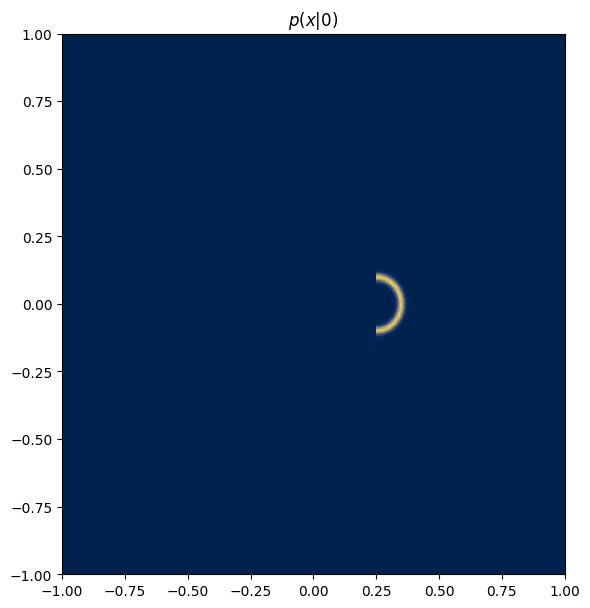

In [3]:
# Plot some distributions to get a sense of the two moons problem
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
x_samples = draw_obs(rng_batch, jnp.array([0.0, 0.0]))

fig = plt.figure(figsize=(6, 6))
n_bins = 1000
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x|0)$')
plt.show()

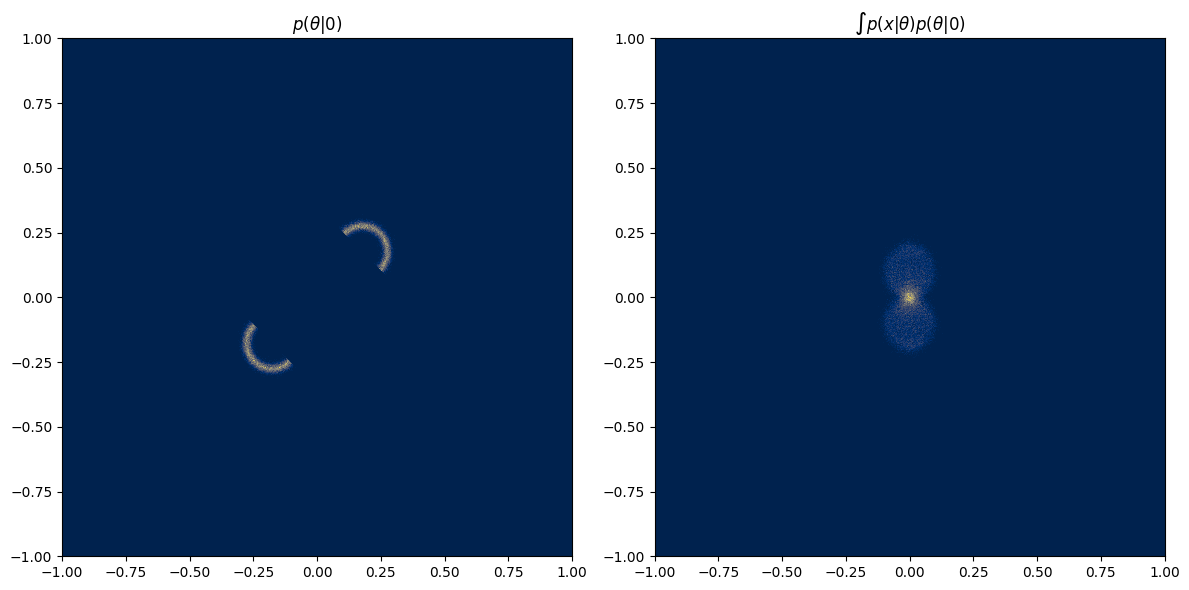

In [4]:
# Plot our target distribution for our context of 0.
batch_size = 100_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
theta_p_x = draw_thetas(rng_batch, jnp.array([0.0, 0.0]))
x_p_x = draw_obs_conds(rng_batch, theta_p_x)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
n_bins = 1000
ax[0].set_title(r'$p(\theta|0)$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
ax[1].set_title(r'$\int p(x|\theta)p(\theta|0)$')
ax[1].hist2d(
    x_p_x[:, 0], x_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

## Training Setup

In [5]:
parameter_dim = 2
n_maf_layers = 5
hidden_dims_maf = [50, 50]
hidden_layers_mlp = []
activation_mlp ='gelu'
activation_maf = 'tanh'
context_dim = 2

embedding_module = embedding_models.MLP(context_dim, hidden_layers_mlp, activation_mlp)
flow_module = maf_flow.MAF(parameter_dim, n_maf_layers, hidden_dims_maf, activation_maf)
model = maf_flow.EmbeddedFlow(embedding_module, flow_module)

# Initialize the train state.
rng = jax.random.PRNGKey(1)
optimizer = 'adam'
learning_rate = 2e-4
training_sample_size = 32
sample_shape = (4096,)

learning_rate_schedule = optax.exponential_decay(learning_rate, 8192, 1.0)
state = train.create_train_state_nf(
    rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule
)

# Create compiled version of functions.
sample_func = jax.jit(
    functools.partial(state.apply_fn, method='sample', mutable=('batch_stats',)),
    static_argnames=['sample_shape',]
)
log_prob_func = jax.jit(
    functools.partial(state.apply_fn, mutable=('batch_stats',))
)
extract_flow_context = jax.jit(train.extract_flow_context)

# If you change the underlying model, you must create a new train_step function since it depends on the
# optimizer mask which depends on the maf_model structure.
train_step = jax.jit(train.train_step, static_argnames=['learning_rate_schedule', 'n_atoms'])

In [6]:
x_obs = jnp.zeros((2))

def train_state(
    x_dataset, theta_dataset, rng, state, n_epochs, batch_size
):
    """Train model from starting state using provided dataset"""

    mu_prior = jnp.zeros(2)
    prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

    # Timing
    train_metrics_last_t = time.time()

    for epoch in range(n_epochs):

        # Sample a batch
        rng, rng_perm = jax.random.split(rng)
        dataset_size = len(x_dataset)
        n_atoms = min(batch_size, 128)

        # Create a batch of indices truncating indices that don't fit in the
        # batch size.
        indices_batch = jax.random.permutation(rng, dataset_size)
        indices_batch = indices_batch[dataset_size % batch_size:]
        indices_batch = indices_batch.reshape((-1, batch_size))

        for indices in indices_batch:
            x_batch = x_dataset[indices]
            theta_batch = theta_dataset[indices]
            batch = {'truth': theta_batch, 'context': x_batch}

            # Update
            state, metrics = train_step(
                rng, state, batch, mu_prior, prec_prior,
                learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
            )

        # Report metrics at the end of each epoch.
        metrics['steps_per_second'] = (
            len(indices_batch) / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_p_x, jnp.zeros_like(x_p_x)
        )
        metrics['kl'] = -jnp.mean(log_obs_prob)
        # print(
        #     f'epoch {(epoch+1):>{2}}:',
        #     jax.tree_map(lambda x: f'{float(x):.3g}', metrics)
        # )

    kl = -jnp.mean(log_obs_prob)

    return state, kl


flow_apply = jax.jit(
    flow_module.apply, static_argnames=['sample_shape', 'method']
)
def sample_thetas(rng, flow_params, context, theta_samp_func, flow_weight):
    """Sample a mixture of the flow outputs and the prior controlled by the
    weight"""
    rng_prior, rng_flow = jax.random.split(rng)

    truth_from_prior = theta_samp_func(rng_prior)

    truth_from_flow = flow_apply(
        flow_params, rng_flow, context, sample_shape=truth_from_prior.shape[:1],
        method='sample'
    )

    # Determine the ratio based off of the flow weight.
    flow_mask = jnp.expand_dims(
        jnp.linspace(0, 1, truth_from_prior.shape[0]) < flow_weight, axis=-1
    )

    truth = truth_from_flow * flow_mask
    truth += truth_from_prior * (~flow_mask)

    return truth

# The prior distribution from which we will sample.
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(training_sample_size, 2), minval=-1.0, maxval=1.0
)

n_seq = 200
n_epochs = 20

states_dict = {}
kl_dict = {}
kl_approx_dict = {}

## NPE - $f_\mathrm{post} = 0.0$

Train a model where every example is drawn from the prior (equivalent to NPE).

In [7]:
# The name of this run
experiment = r'NPE ($f_{\mathrm{post}}=0.0$)'
states_dict[experiment] = [state]
kl_dict[experiment] = []
kl_approx_dict[experiment] = []
# First state is blank state.
state_train = state

# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_x = jax.random.split(rng_x, training_sample_size)
xs = draw_obs_conds(rng_x, thetas)

rng = jax.random.PRNGKey(2)
# Flow weight is always 0 for this experiment.
flow_weight = 0.0
n_epochs = 5
for seq_round in range(n_seq):

    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    batch_size = min(256, len(xs)) # Batch shouldn't be larger than the dataset.
    state_train, kl = train_state(
        xs, thetas, rng_train, state_train, n_epochs, batch_size
    )

    # Save the new state and the kl.
    states_dict[experiment].append(state_train)
    kl_dict[experiment].append(kl)
    print(f'Sequential round {seq_round}: {kl}, {flow_weight}')

    # Get the new flow from the model and generate the new batch.
    flow_params, context = extract_flow_context(state_train, x_obs)
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_x = jax.random.split(rng, training_sample_size)
    x_batch = draw_obs_conds(rng_x, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0: 1.942970633506775, 0.0
Sequential round 1: 1.9993051290512085, 0.0
Sequential round 2: 2.0495567321777344, 0.0
Sequential round 3: 2.0876681804656982, 0.0
Sequential round 4: 2.1097662448883057, 0.0
Sequential round 5: 2.1150243282318115, 0.0
Sequential round 6: 2.1041393280029297, 0.0
Sequential round 7: 2.0780627727508545, 0.0
Sequential round 8: 2.038036584854126, 0.0
Sequential round 9: 1.9859833717346191, 0.0
Sequential round 10: 1.923179030418396, 0.0
Sequential round 11: 1.851355791091919, 0.0
Sequential round 12: 1.7716137170791626, 0.0
Sequential round 13: 1.6834542751312256, 0.0
Sequential round 14: 1.5885730981826782, 0.0
Sequential round 15: 1.387347936630249, 0.0
Sequential round 16: 1.1960554122924805, 0.0
Sequential round 17: 1.0396218299865723, 0.0
Sequential round 18: 0.9023515582084656, 0.0
Sequential round 19: 0.7149595022201538, 0.0
Sequential round 20: 0.4847409725189209, 0.0
Sequential round 21: 0.26295167207717896, 0.0
Sequential round 22: 0.0

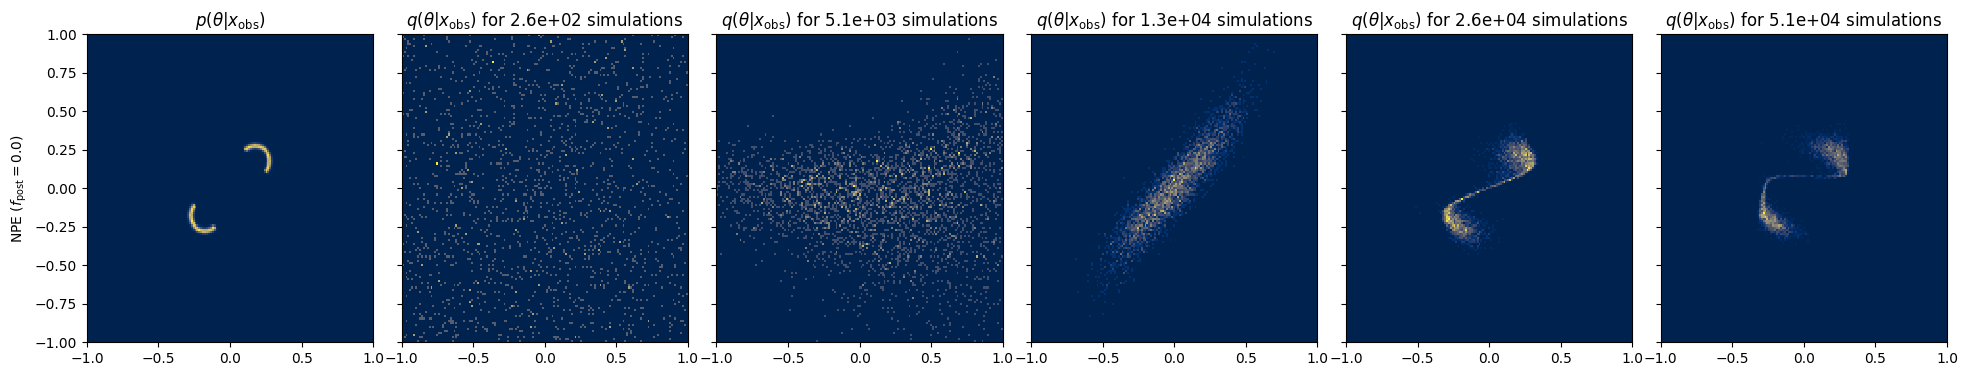

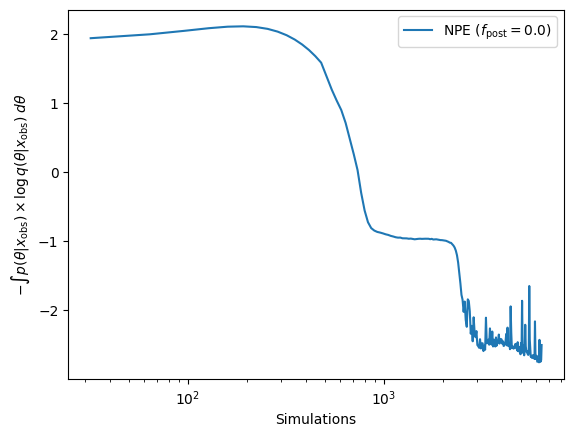

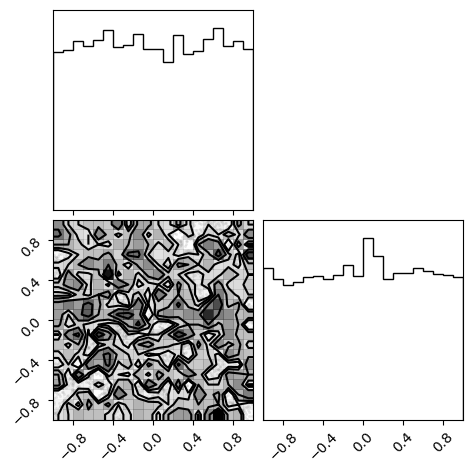

In [8]:
def plot_samples(plt_indices = [1, 10, 20, 30, 40, 50]):

    # Create the figure where we'll store the sample plots
    n_exp = len(states_dict)
    fig, ax = plt.subplots(
        n_exp, len(plt_indices) + 1,
        figsize=(4 * (len(plt_indices) + 1), 4 * n_exp), sharey=True,
        sharex=True, gridspec_kw={'hspace': 0.1,'wspace':0.1}, dpi=100
    )

    if n_exp == 1:
        ax = ax[None]

    n_bins = 150

    ax[0, 0].set_title(r'$p(\theta|x_\mathrm{obs})$')
    for k_i, key in enumerate(states_dict):
        ax[k_i, 0].hist2d(
            theta_p_x[:, 0], theta_p_x[:, 1],
            bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
        )
        ax[k_i,0].set_ylabel(key)

        for plt_i, i in enumerate(plt_indices):
            t_samp, _ = sample_func(
                {'params': states_dict[key][i].params, 'batch_stats': states_dict[key][i].batch_stats},
                rng, x_obs[None],
                sample_shape=sample_shape
            )
            t_samp = jnp.squeeze(t_samp)
            if k_i == 0:
                ax[k_i, plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * (i):.1e} simulations')
            ax[k_i, plt_i+1].hist2d(
                t_samp[:, 0], t_samp[:, 1],
                bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
            )
    plt.show()

plot_samples(plt_indices = [1, 20, 50, 100, 200])
for key in kl_dict:
    plt.plot(
        jnp.arange(1, len(kl_dict[key])+1) * training_sample_size,
        jnp.array(kl_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

corner.corner(np.array(thetas))
plt.show()

## SNPE - $f_\mathrm{post} = 1.0$

Train a model where every new example is drawn from the posterior (SNPE-C)

In [9]:
# The name of this run
experiment = r'SNPE-C ($f_\mathrm{post}=1.0$)'
states_dict[experiment] = [state]
kl_dict[experiment] = []
kl_approx_dict[experiment] = []
# First state is blank state.
state_train = state

# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_x = jax.random.split(rng_x, training_sample_size)
xs = draw_obs_conds(rng_x, thetas)

rng = jax.random.PRNGKey(2)
# Flow weight is always 0 for this experiment.
flow_weight = 1.0
for seq_round in range(n_seq):

    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    batch_size = min(256, len(xs)) # Batch shouldn't be larger than the dataset.
    state_train, kl = train_state(
        xs, thetas, rng_train, state_train, n_epochs, batch_size
    )

    # Save the new state and the kl.
    states_dict[experiment].append(state_train)
    kl_dict[experiment].append(kl)
    print(f'Sequential round {seq_round}: {kl}, {flow_weight}')

    # Get the new flow from the model and generate the new batch.
    flow_params, context = extract_flow_context(state_train, x_obs)
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_x = jax.random.split(rng, training_sample_size)
    x_batch = draw_obs_conds(rng_x, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0: 1.9494974613189697, 1.0
Sequential round 1: 2.00050687789917, 1.0
Sequential round 2: 2.0569398403167725, 1.0
Sequential round 3: 2.111673355102539, 1.0
Sequential round 4: 2.1586811542510986, 1.0
Sequential round 5: 2.1944165229797363, 1.0
Sequential round 6: 2.2207939624786377, 1.0
Sequential round 7: 2.2381138801574707, 1.0
Sequential round 8: 2.247133493423462, 1.0
Sequential round 9: 2.253384590148926, 1.0
Sequential round 10: 2.2574005126953125, 1.0
Sequential round 11: 2.2562592029571533, 1.0
Sequential round 12: 2.2490768432617188, 1.0
Sequential round 13: 2.2376224994659424, 1.0
Sequential round 14: 2.2221662998199463, 1.0
Sequential round 15: 2.1786551475524902, 1.0
Sequential round 16: 2.1207690238952637, 1.0
Sequential round 17: 2.046778917312622, 1.0
Sequential round 18: 1.9570690393447876, 1.0
Sequential round 19: 1.8514033555984497, 1.0
Sequential round 20: 1.7316303253173828, 1.0
Sequential round 21: 1.6035373210906982, 1.0
Sequential round 22: 1.476

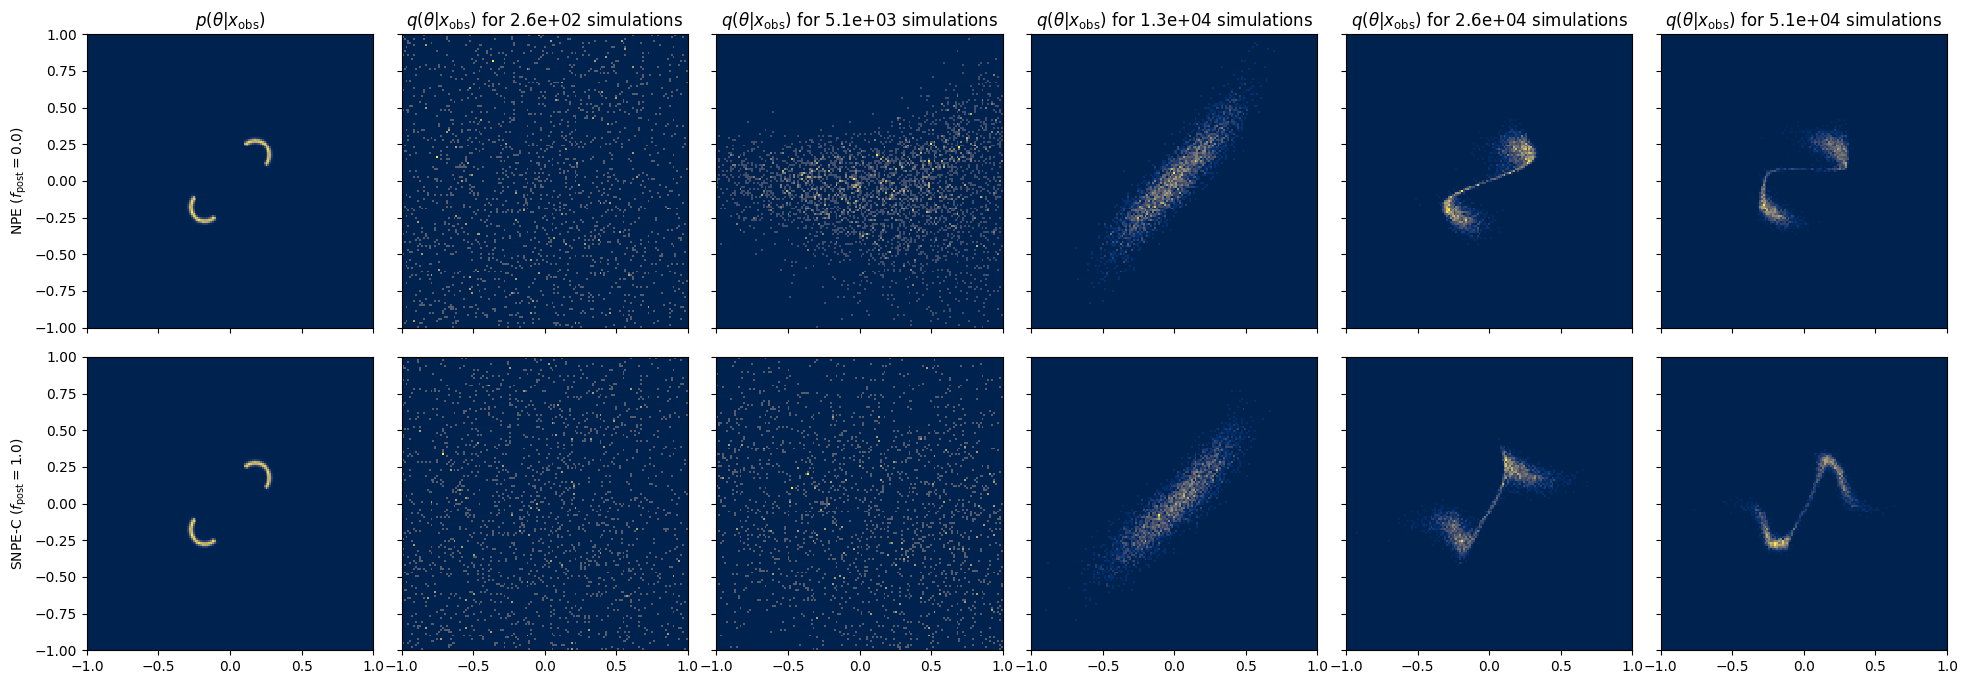

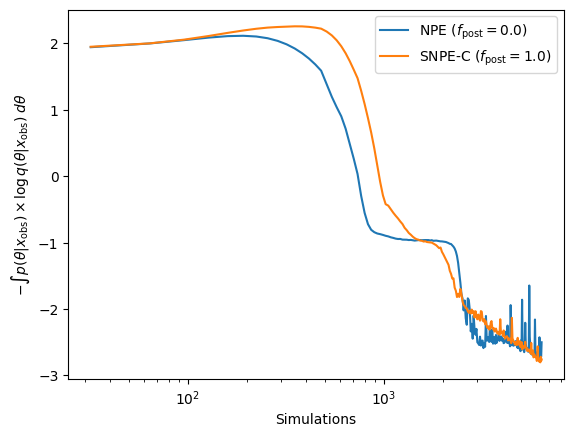

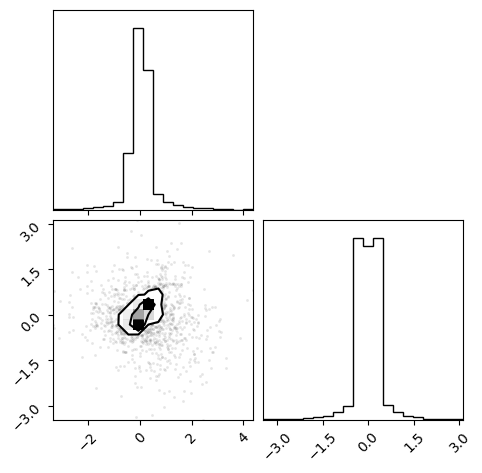

In [10]:
plot_samples(plt_indices = [1, 20, 50, 100, 200])
for key in kl_dict:
    plt.plot(
        jnp.arange(1, len(kl_dict[key])+1) * training_sample_size,
        jnp.array(kl_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

corner.corner(np.array(thetas))
plt.show()

## Bayesian Optimization $f_\mathrm{post}$

Train a model where the fraction is selected through Bayesian optimization.

### Uniform Sampling

In [84]:
# The name of this run
experiment = r'Uniform $f_\mathrm{post}$'
states_dict[experiment] = [state]
kl_dict[experiment] = []
kl_approx_dict[experiment] = []
flow_weight_list = []
# First state is blank state.
state_train = state

# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
flow_weight = 0.0
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, flow_weight)
rng_x = jax.random.split(rng_x, training_sample_size)
xs = draw_obs_conds(rng_x, thetas)

rng = jax.random.PRNGKey(2)
# Flow weight is always 0 for this experiment.
for seq_round in range(n_seq):

    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    batch_size = min(256, len(xs)) # Batch shouldn't be larger than the dataset.
    state_train, kl = train_state(
        xs, thetas, rng_train, state_train, n_epochs, batch_size
    )

    # Save the new state and the kl.
    states_dict[experiment].append(state_train)
    flow_weight_list.append(flow_weight)
    kl_dict[experiment].append(kl)
    print(f'Sequential round {seq_round}: {kl}, {flow_weight}')

    # Approximate kl
    approx_samples, _ = sample_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    log_obs_prob, _ = log_prob_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        approx_samples[0], jnp.zeros_like(approx_samples[0])
    )
    kl_approx_dict[experiment].append(-jnp.mean(log_obs_prob))

    # Get the new flow from the model and generate the new batch.
    flow_weight = jax.random.uniform(rng, minval=0.0, maxval=1.0)
    flow_params, context = extract_flow_context(state_train, x_obs)
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_x = jax.random.split(rng, training_sample_size)
    x_batch = draw_obs_conds(rng_x, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0: 1.9494974613189697, 0.0
Sequential round 1: 2.0073037147521973, 0.3748607635498047
Sequential round 2: 2.069575309753418, 0.9686962366104126
Sequential round 3: 2.1300606727600098, 0.7055308818817139
Sequential round 4: 2.1809146404266357, 0.33790647983551025
Sequential round 5: 2.218503952026367, 0.43701374530792236
Sequential round 6: 2.247011184692383, 0.7743562459945679
Sequential round 7: 2.266728639602661, 0.8798863887786865
Sequential round 8: 2.276822566986084, 0.8927942514419556
Sequential round 9: 2.2851312160491943, 0.9979972839355469
Sequential round 10: 2.2895452976226807, 0.20234251022338867
Sequential round 11: 2.283656120300293, 0.6875802278518677
Sequential round 12: 2.266794204711914, 0.0649343729019165
Sequential round 13: 2.240540027618408, 0.6350212097167969
Sequential round 14: 2.2075722217559814, 0.9228624105453491
Sequential round 15: 2.118922233581543, 0.2945895195007324
Sequential round 16: 2.0045604705810547, 0.581676721572876
Sequential r

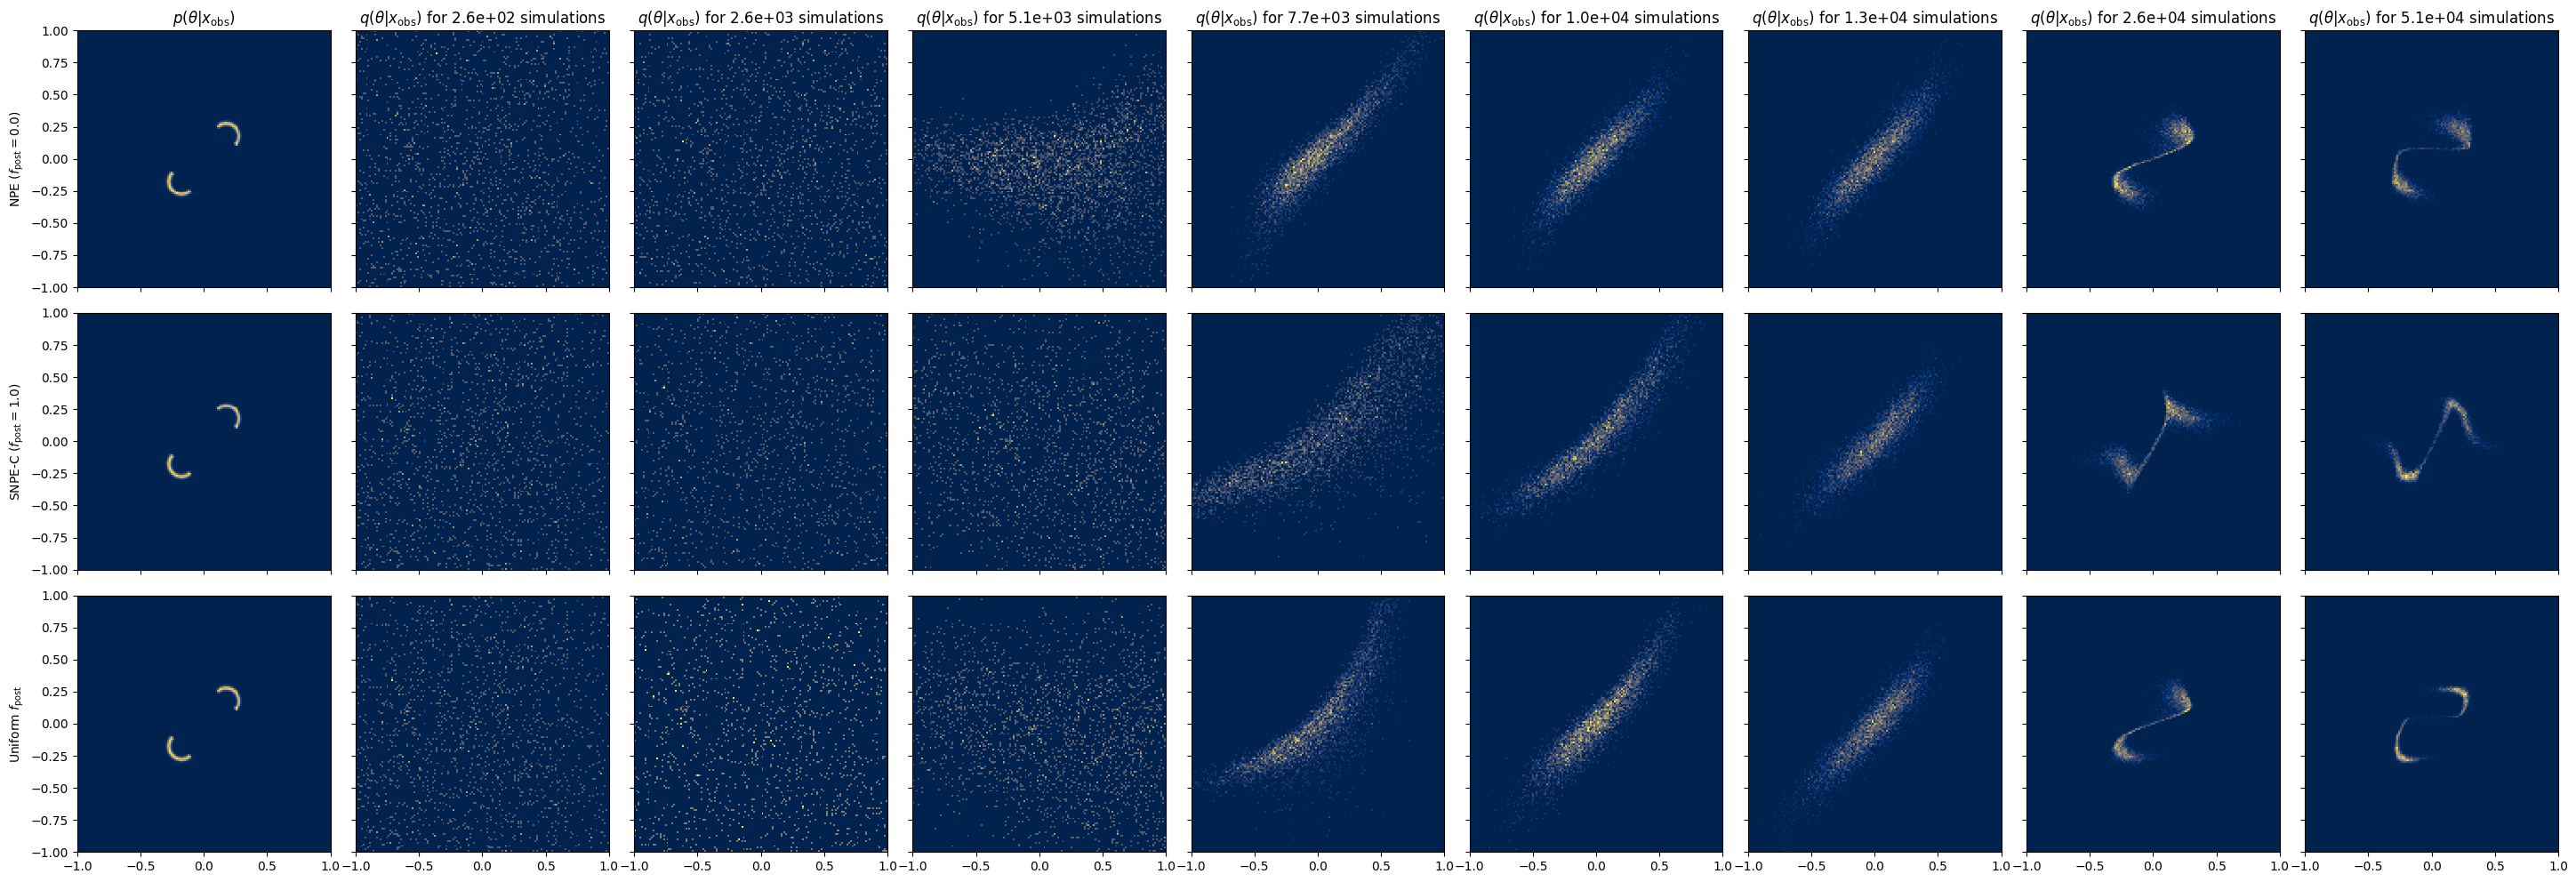

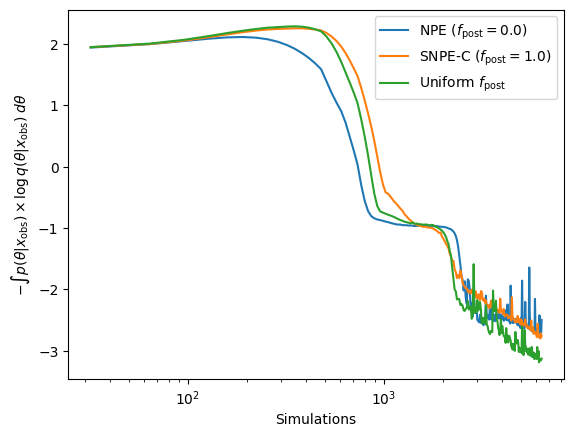

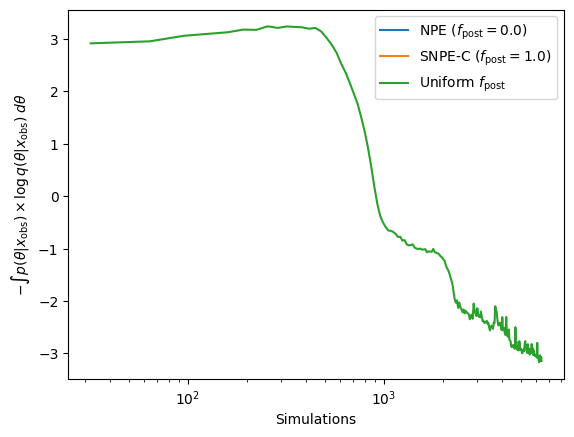

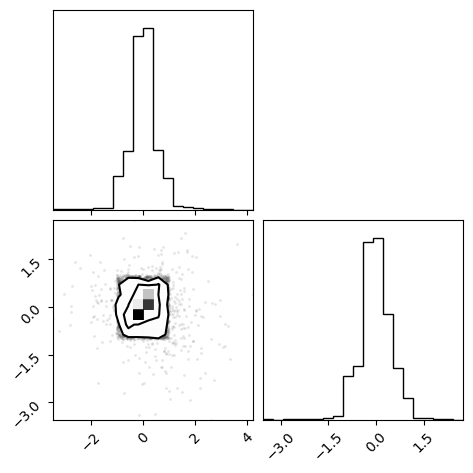

In [85]:
plot_samples(plt_indices = [1, 10, 20, 30, 40, 50, 100, 200])

for key in kl_dict:
    plt.plot(
        jnp.arange(1, len(kl_dict[key])+1) * training_sample_size,
        jnp.array(kl_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

for key in kl_approx_dict:
    plt.plot(
        jnp.arange(1, len(kl_approx_dict[key])+1) * training_sample_size,
        jnp.array(kl_approx_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

corner.corner(np.array(thetas))
plt.show()

### Gaussian Process Implementation

The basic pieces of the GP implementation as well as a few tests of its performance on the uniform samples.

In [220]:
n_seq

200

In [221]:
# A bunch of function to train and plot the GP

def get_new_gp(n_feats = 1):
    """Generate a Gaussian Process class."""
    kernel = (
        ConstantKernel(0.1, (1e-7, 1e5)) * RBF(np.array([1/training_sample_size] * n_feats), 'fixed') +
        ConstantKernel(0.1, (1e-7, 1e5)) * RBF(np.array([1e-1] * n_feats), 'fixed') +
        WhiteKernel(1e-2, (1e-5, 1e5))
    )
    gp = GaussianProcessRegressor(
        kernel=kernel, n_restarts_optimizer=30, alpha=1e-10,
        normalize_y=False
    )
    return gp

def exploitation(mean, sigma, f_prime):
    """Exploitation terms in the expected improvement calculation."""
    return (f_prime - mean) * norm.cdf(f_prime, loc=mean, scale=sigma)

def exploration(mean, sigma, f_prime):
    """Exploration terms in the expected improvement calculation."""
    return sigma ** 2 * norm.pdf(f_prime, loc=mean, scale=sigma)

def expected_improvement(mean, sigma, f_prime):
    """Generate the expected improvement given the Gaussian Process predictions.

    Args:
        mean: Mean GP prediction at each test point.
        sigma: Standard deviation in GP prediction at each test point.
        f_prime: Maximum f value achieved thus far.

    Returns:
        Expected improvement at each tested point.
    """
    return (
        exploitation(mean, sigma, f_prime) + exploration(mean, sigma, f_prime)
    )

def create_gp_plots(features, f_vals, feat_test, mean, sigma, title=None):
    f, axes = plt.subplots(
        4, 1, figsize=(12, 8), sharex=False, sharey=False,
        gridspec_kw={'hspace': 0.05,'wspace':0.02}, dpi=100
    )

    axes[0].scatter(features[:,1], f_vals, c=features[:,0], cmap='Greys', s=9)
    axes[0].fill_between(
        feat_test[:,1], (mean-sigma), (mean+sigma), alpha=0.2, color='#2ca25f'
    )
    axes[0].plot(feat_test[:,1], mean, color='#2ca25f')
    axes[0].set_ylabel(r'$\Delta$ KL')

    axes[1].plot(feat_test[:,1], mean, color='#2ca25f')
    axes[1].set_ylabel(r'$\Delta$ KL')

    axes[2].plot(
        feat_test[:,1], exploitation(mean, sigma, np.min(f_vals)),
        color='#31a354', label='Exploitation'
    )
    axes[2].plot(
        feat_test[:,1], exploration(mean, sigma, np.min(f_vals)),
        color='#e34a33', label='Exploration'
    )
    axes[2].legend()
    axes[2].set_ylabel(r'Exploration / Exploitation')

    axes[3].plot(
        feat_test[:,1], expected_improvement(mean, sigma, np.min(f_vals)),
        color='k', label='Expected Improvement'
    )
    axes[3].set_ylabel('Expected Improvement')
    axes[3].set_xlabel(r'$f_\mathrm{post}$')

    # Label the optimal next choice
    next_f = feat_test[
        np.argmax(expected_improvement(mean, sigma, np.min(f_vals))), 1
    ]
    for ax in axes:
        ax.axvline(next_f, c='k', lw=2)

    if title is not None:
        axes[0].set_title(title)

    plt.show()

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


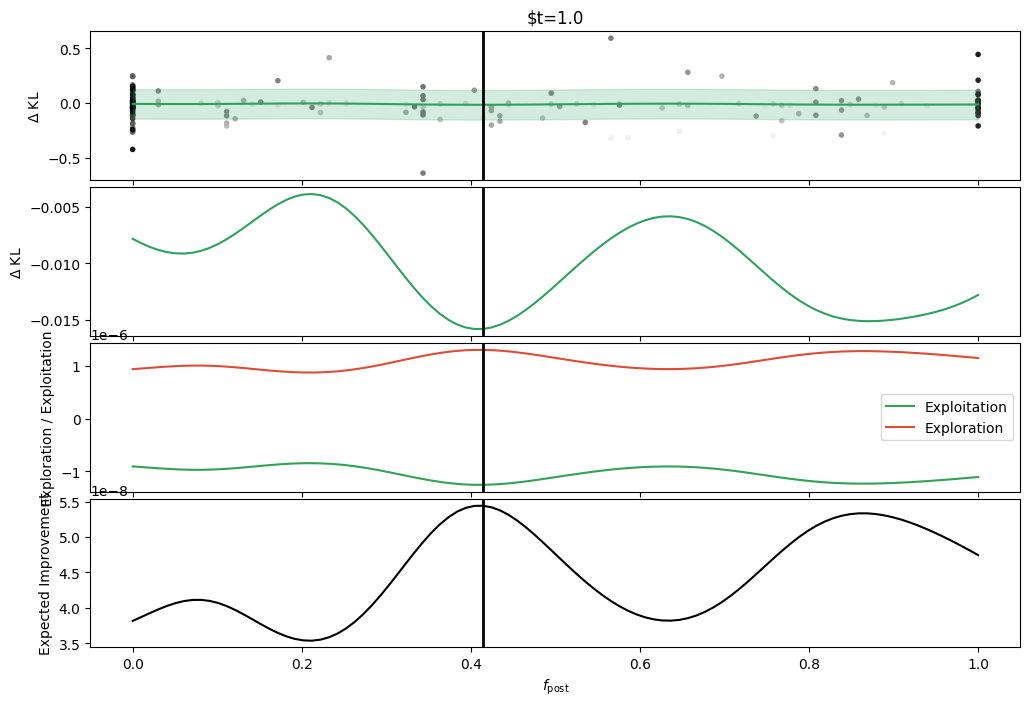

In [222]:
# Generate the features without time and see how the prediction changes.
features = jnp.stack(
    [
        jnp.linspace(0, 1, len(flow_weight_list[1:])),
        jnp.array(flow_weight_list)[1:]
    ],
    axis=1
)

# The value we're modeling is the change in the KL for our experiment
experiment = r'$f_\mathrm{post}$ BO'
f_vals = jnp.array(kl_dict[experiment])
f_vals = f_vals[1:] - f_vals[:-1]

# Fit the GP without time and see how well it explains the data.
gp = get_new_gp(1)
gp.fit(features[:,1:], f_vals)
feat_test = jnp.stack([jnp.ones(100), jnp.linspace(0,1,100)], axis=1)
mean, sigma = gp.predict(feat_test[:, 1:], return_std=True)
create_gp_plots(features, f_vals, feat_test, mean, sigma, title=r'$t=1.0')

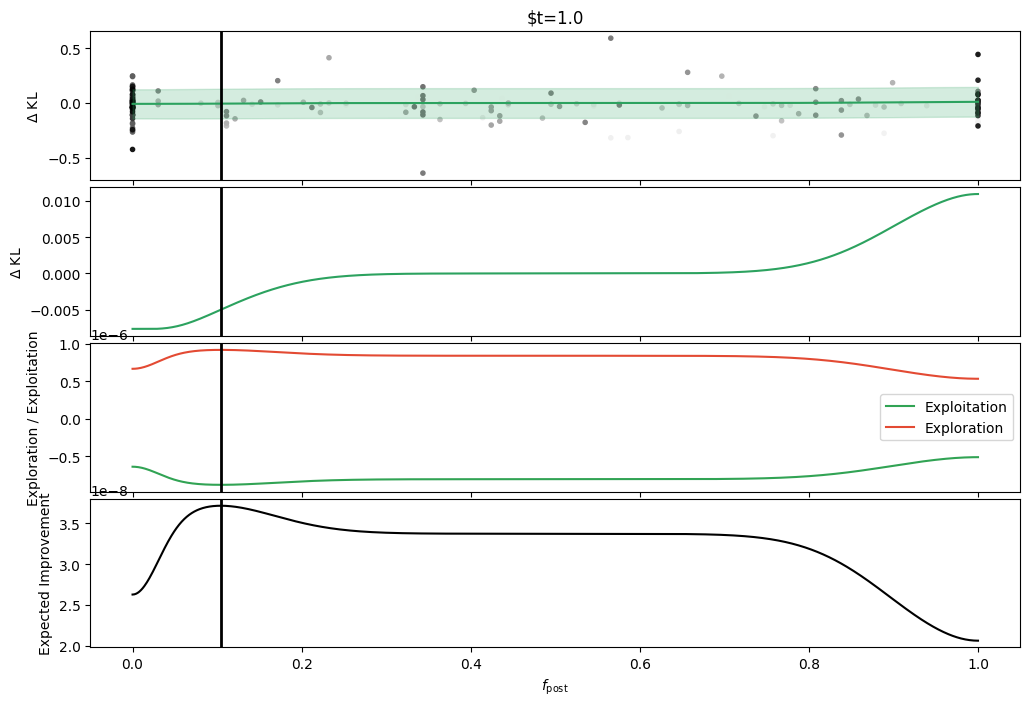

In [225]:
# Fit the GP with time and see how well it explains the data.
gp = get_new_gp(1)
gp.fit(features, f_vals)

feat_test = jnp.stack([jnp.ones(1000), jnp.linspace(0,1,1000)], axis=1)
mean, sigma = gp.predict(feat_test, return_std=True)
create_gp_plots(features, f_vals, feat_test, mean, sigma, title=r'$t=1.0')

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


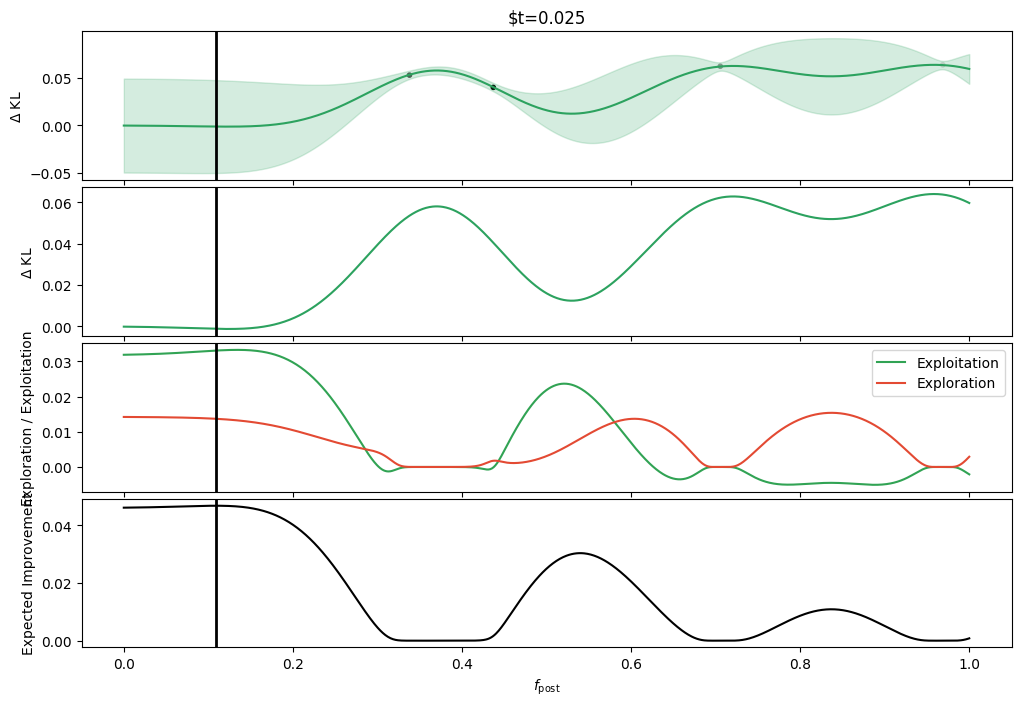

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


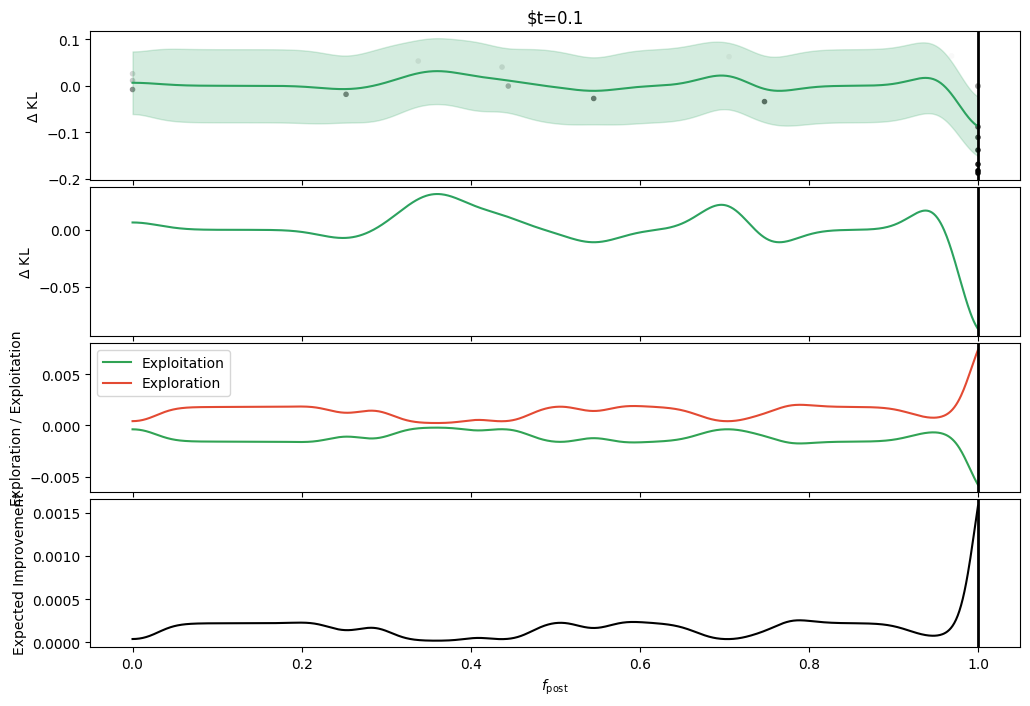

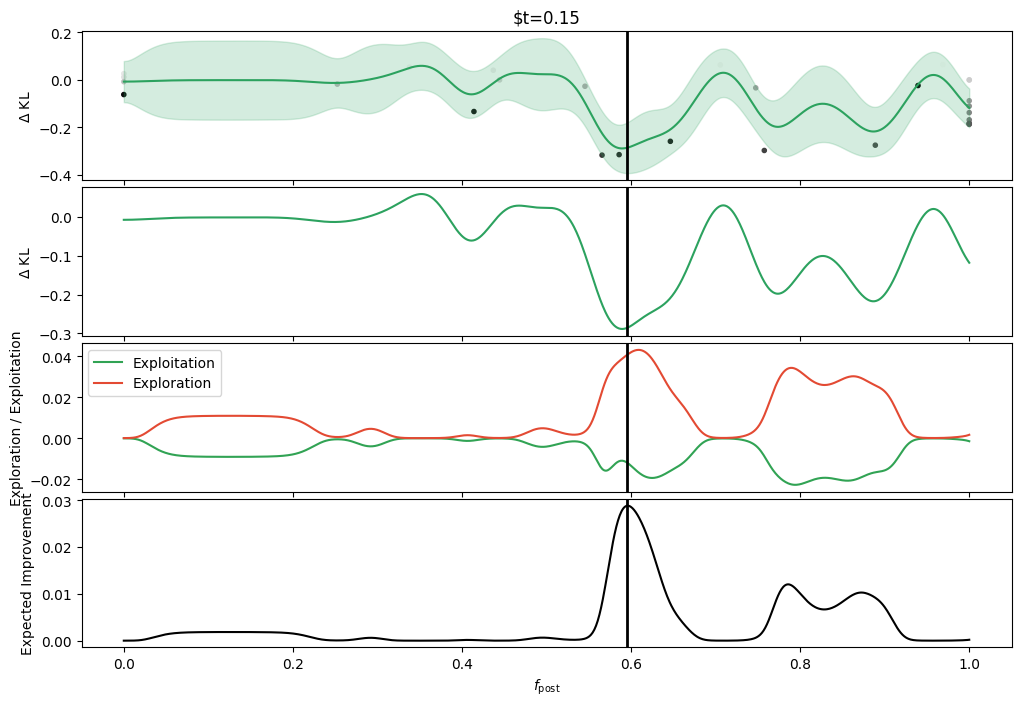

In [226]:
# Try simulating how the GP evolves throughout the observations.
for cut in [5, 20, 30]:
    gp = get_new_gp(1)
    gp.fit(features[:cut,1:], f_vals[:cut])

    feat_test = jnp.stack([jnp.ones(1000) * features[cut,0], jnp.linspace(0,1,1000)], axis=1)
    mean, sigma = gp.predict(feat_test[:,1:], return_std=True)
    create_gp_plots(features[:cut], f_vals[:cut], feat_test, mean, sigma, title=f'$t={cut/200}')

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


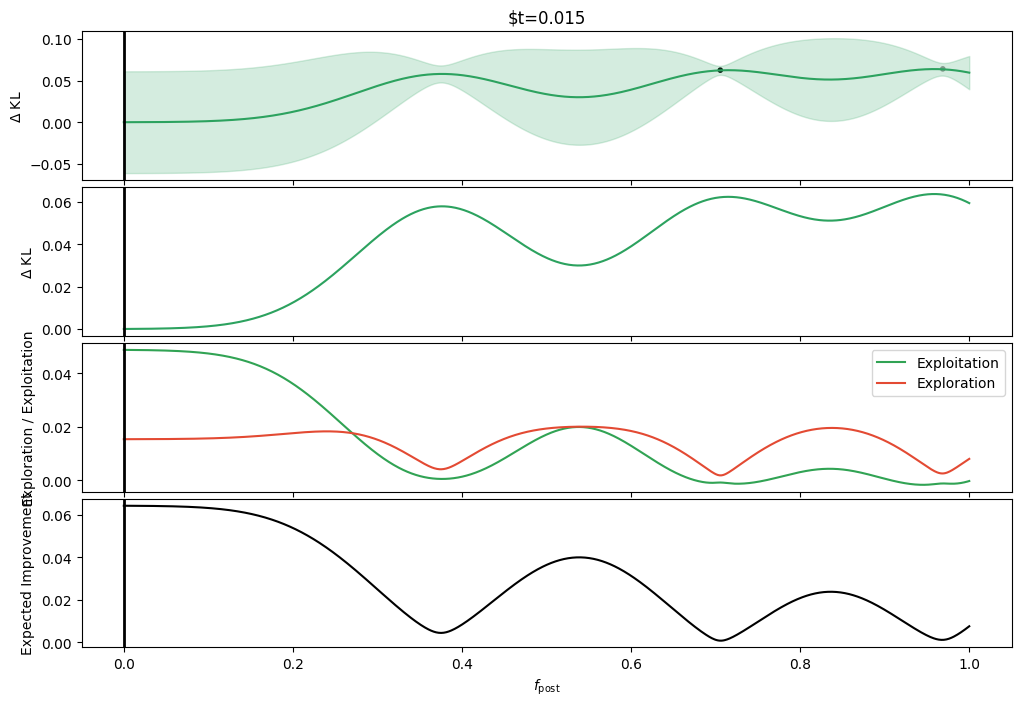

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


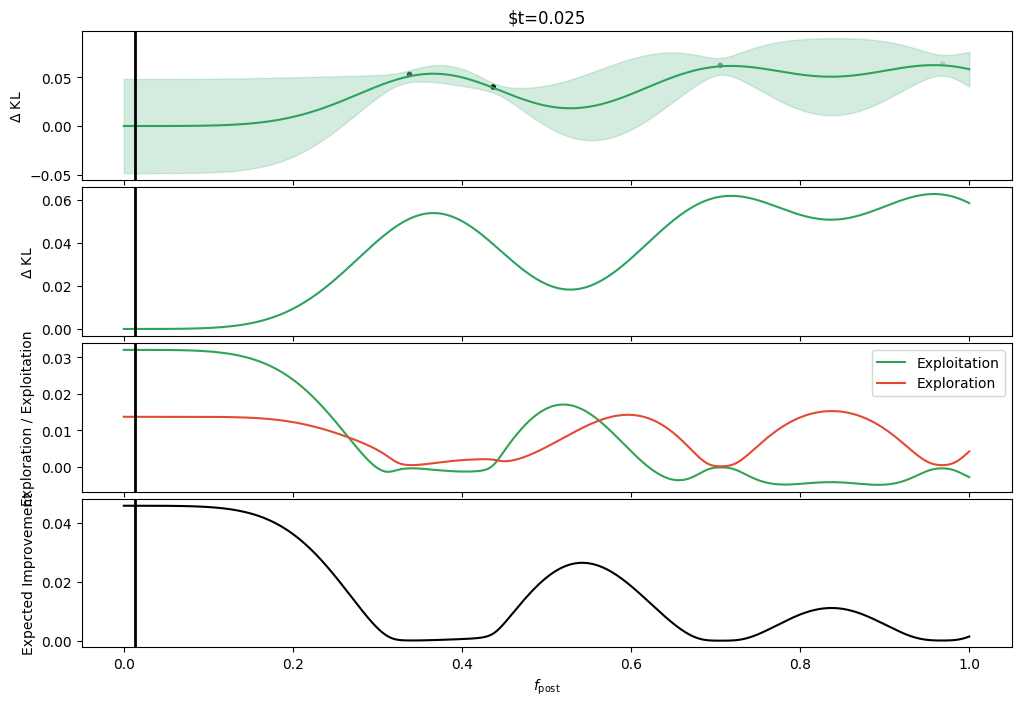

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


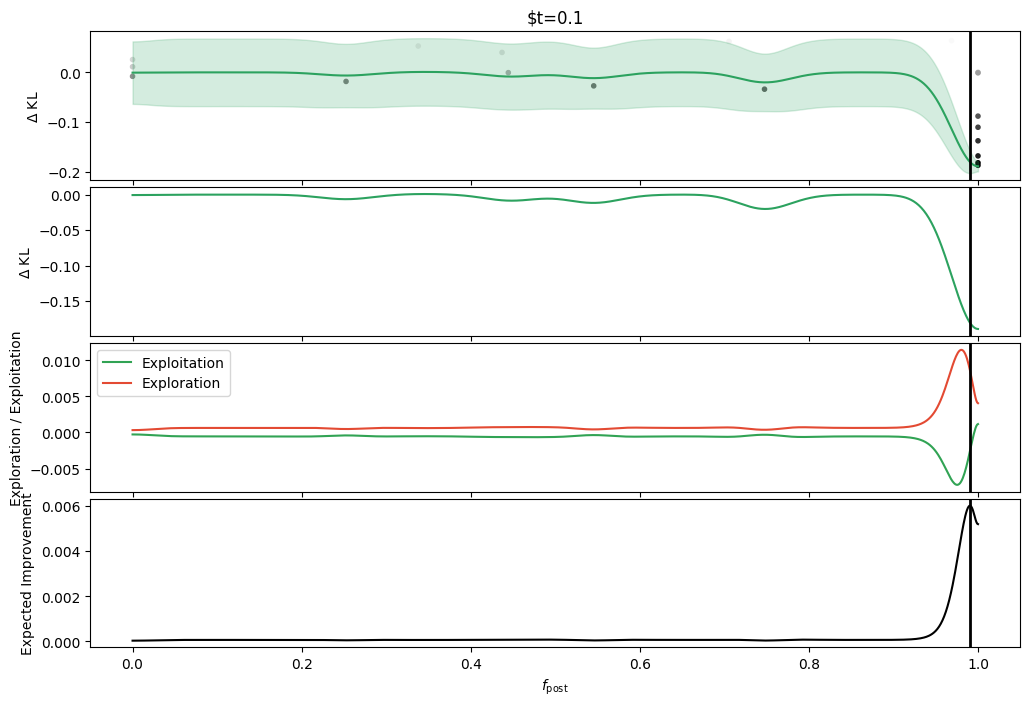

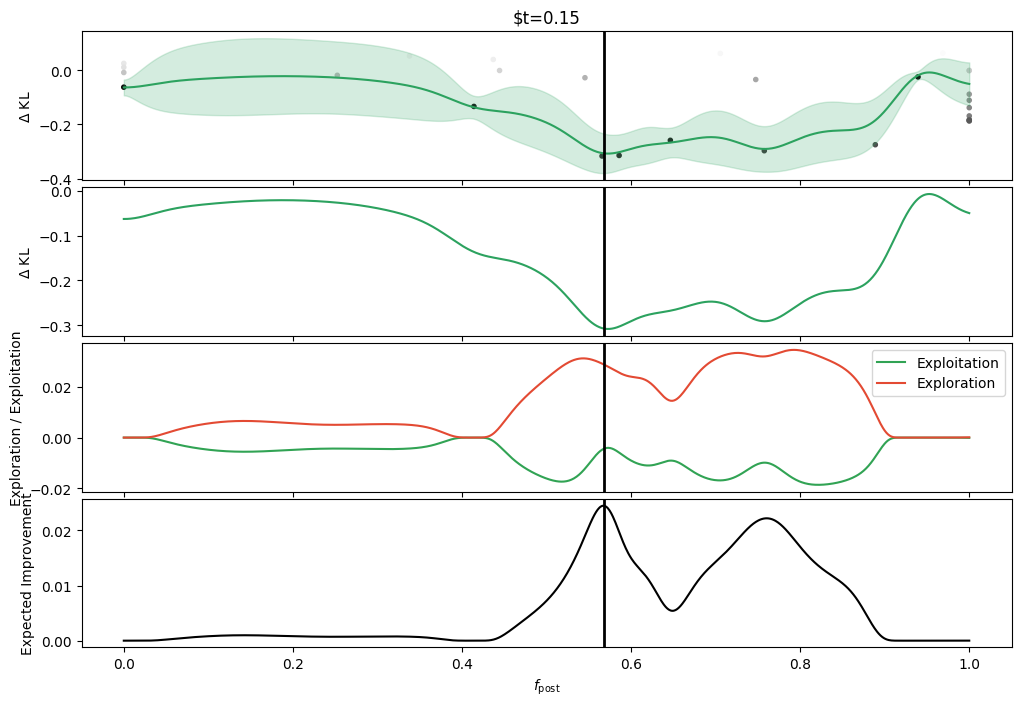

In [227]:
# Try simulating how the GP evolves throughout the observations.
for cut in [3, 5, 20, 30]:
    gp = get_new_gp(1)
    gp.fit(features[:cut], f_vals[:cut])

    feat_test = jnp.stack([jnp.ones(1000) * features[cut,0], jnp.linspace(0,1,1000)], axis=1)
    mean, sigma = gp.predict(feat_test, return_std=True)
    create_gp_plots(features[:cut], f_vals[:cut], feat_test, mean, sigma, title=f'$t={cut/200}')

In [228]:
# The name of this run
experiment = r'$f_\mathrm{post}$ BO'
states_dict[experiment] = [state]
kl_dict[experiment] = []
kl_approx_dict[experiment] = []
flow_weight_list = []
# First state is blank state.
state_train = state

# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
flow_weight = 0.0
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, flow_weight)
rng_x = jax.random.split(rng_x, training_sample_size)
xs = draw_obs_conds(rng_x, thetas)

rng = jax.random.PRNGKey(2)
# Flow weight is always 0 for this experiment.
for seq_round in range(n_seq):

    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    batch_size = min(256, len(xs)) # Batch shouldn't be larger than the dataset.
    state_train, kl = train_state(
        xs, thetas, rng_train, state_train, n_epochs, batch_size
    )

    # Save the new state and the kl.
    states_dict[experiment].append(state_train)
    flow_weight_list.append(flow_weight)
    kl_dict[experiment].append(kl)
    print(f'Sequential round {seq_round}: {kl}, {flow_weight}')

    # Approximate kl
    approx_samples, _ = sample_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    log_obs_prob, _ = log_prob_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        approx_samples[0], jnp.zeros_like(approx_samples[0])
    )
    kl_approx_dict[experiment].append(-jnp.mean(log_obs_prob))

    # First samples are uniform, then we use GP fit.
    if seq_round < 5:
        flow_weight = jax.random.uniform(rng, minval=0.0, maxval=1.0)
    else:
        features = jnp.stack(
            [
                jnp.linspace(0, 1, len(flow_weight_list[1:]), endpoint=False),
                jnp.array(flow_weight_list)[1:]
            ],
            axis=1
        )

        # The value we're modeling is the change in the KL for our experiment
        f_vals = jnp.array(kl_dict[experiment])
        f_vals = f_vals[1:] - f_vals[:-1]

        # Fit the GP
        gp = get_new_gp(1)
        gp.fit(features, f_vals)
        feat_test = jnp.stack([jnp.ones(1000), jnp.linspace(0,1,1000)], axis=1)

        # Use the GP to predict the best next weight
        f_prime = np.min(f_vals)
        mean, sigma = gp.predict(feat_test, return_std=True)
        next_index = np.argmax(expected_improvement(mean, sigma, f_prime))
        flow_weight = feat_test[next_index, 1]

    # Get the new flow from the model and generate the new batch.
    flow_params, context = extract_flow_context(state_train, x_obs)
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_x = jax.random.split(rng, training_sample_size)
    x_batch = draw_obs_conds(rng_x, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0: 1.9494974613189697, 0.0
Sequential round 1: 2.0073037147521973, 0.3748607635498047
Sequential round 2: 2.069575309753418, 0.9686962366104126
Sequential round 3: 2.1300606727600098, 0.7055308818817139
Sequential round 4: 2.1809146404266357, 0.33790647983551025
Sequential round 5: 2.218503952026367, 0.43701374530792236


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 6: 2.2471420764923096, 0.9759759902954102


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 7: 2.266160249710083, 0.0


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 8: 2.274085283279419, 0.5925925970077515


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 9: 2.2802302837371826, 1.0


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 10: 2.2828614711761475, 0.2532532513141632


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 11: 2.275937795639038, 0.7237237095832825


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 12: 2.259430170059204, 0.5725725889205933


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 13: 2.234619617462158, 0.6696696877479553


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 14: 2.203394889831543, 0.586586594581604


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 15: 2.1199185848236084, 0.6626626253128052


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 16: 2.0111544132232666, 0.6776776909828186


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 17: 1.8765636682510376, 0.6446446180343628


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 18: 1.7177584171295166, 0.6526526212692261


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 19: 1.5450752973556519, 0.6356356143951416


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 20: 1.3800439834594727, 0.6706706881523132


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 21: 1.2188349962234497, 0.6156156063079834


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 22: 1.0502415895462036, 0.6666666865348816


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 23: 0.7860789895057678, 0.6396396160125732


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 24: 0.5060534477233887, 0.6226226091384888


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 25: 0.19978368282318115, 0.6516516208648682


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 26: -0.12723222374916077, 0.630630612373352


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 27: -0.42570582032203674, 0.6236236095428467


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 28: -0.6167762875556946, 0.6826826930046082


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 29: -0.7013526558876038, 0.5455455183982849


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 30: -0.7263965606689453, 0.0030030030757188797


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 31: -0.7463198304176331, 0.21921922266483307


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 32: -0.7733385562896729, 1.0


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 33: -0.7909058332443237, 0.8228228092193604


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 34: -0.816509485244751, 0.3733733594417572


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 35: -0.831419050693512, 0.0800800770521164


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 36: -0.8519273996353149, 0.6396396160125732


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 37: -0.8692944049835205, 0.9509509205818176
Sequential round 38: -0.8838000297546387, 0.24824824929237366
Sequential round 39: -0.8982771635055542, 0.4764764606952667
Sequential round 40: -0.9071233868598938, 0.7787787914276123
Sequential round 41: -0.9167709946632385, 0.0
Sequential round 42: -0.9238481521606445, 0.6176176071166992
Sequential round 43: -0.9158422350883484, 1.0
Sequential round 44: -0.9289093613624573, 0.34634634852409363
Sequential round 45: -0.9272227883338928, 0.15415415167808533
Sequential round 46: -0.9327042102813721, 0.8318318128585815
Sequential round 47: -0.9383212327957153, 0.49849849939346313
Sequential round 48: -0.9364455938339233, 0.0
Sequential round 49: -0.9453493356704712, 0.6786786913871765
Sequential round 50: -0.9451223015785217, 1.0
Sequential round 51: -0.9372090101242065, 0.2832832932472229
Sequential round 52: -0.950182318687439, 0.8308308124542236
Sequential round 53: -0.9540923237800598, 0.11611611396074295
Sequential round 54

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 73: -2.136183500289917, 0.935935914516449


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 74: -2.2114627361297607, 0.8558558225631714


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 75: -2.275576591491699, 0.20020020008087158


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 76: -2.268083095550537, 0.053053051233291626


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 77: -2.2688753604888916, 0.342342346906662


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 78: -2.270064115524292, 0.9189189076423645


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 79: -2.3075485229492188, 0.6526526212692261


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 80: -2.31144118309021, 0.5135135054588318


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 81: -2.307368755340576, 0.7677677273750305


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 82: -2.3996033668518066, 0.18818818032741547


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 83: -2.4010705947875977, 0.26526525616645813


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 84: -2.3590757846832275, 0.10910911113023758


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 85: -2.388767719268799, 0.6026026010513306


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 86: -2.3761260509490967, 1.0


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 87: -2.4659006595611572, 0.42642641067504883


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 88: -2.4840235710144043, 0.5025025010108948


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 89: -2.4786388874053955, 0.34834834933280945


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 90: -2.4898693561553955, 0.7007007002830505
Sequential round 91: -2.387024402618408, 0.0
Sequential round 92: -2.5360748767852783, 0.8578578233718872
Sequential round 93: -2.567174196243286, 0.913913905620575
Sequential round 94: -2.5276527404785156, 0.8078078031539917
Sequential round 95: -2.612635850906372, 0.44844844937324524
Sequential round 96: -2.4474198818206787, 0.5425425171852112
Sequential round 97: -2.5964205265045166, 0.2942942976951599
Sequential round 98: -2.5795674324035645, 0.34934934973716736
Sequential round 99: -2.6454923152923584, 0.24724724888801575
Sequential round 100: -2.339369058609009, 0.16516515612602234
Sequential round 101: -2.297917366027832, 0.9729729294776917
Sequential round 102: -2.363736152648926, 0.2952952980995178
Sequential round 103: -2.418459415435791, 0.8458458185195923
Sequential round 104: -2.5468482971191406, 0.7567567229270935
Sequential round 105: -2.4893665313720703, 0.7017017006874084
Sequential round 106: -2.647830486297

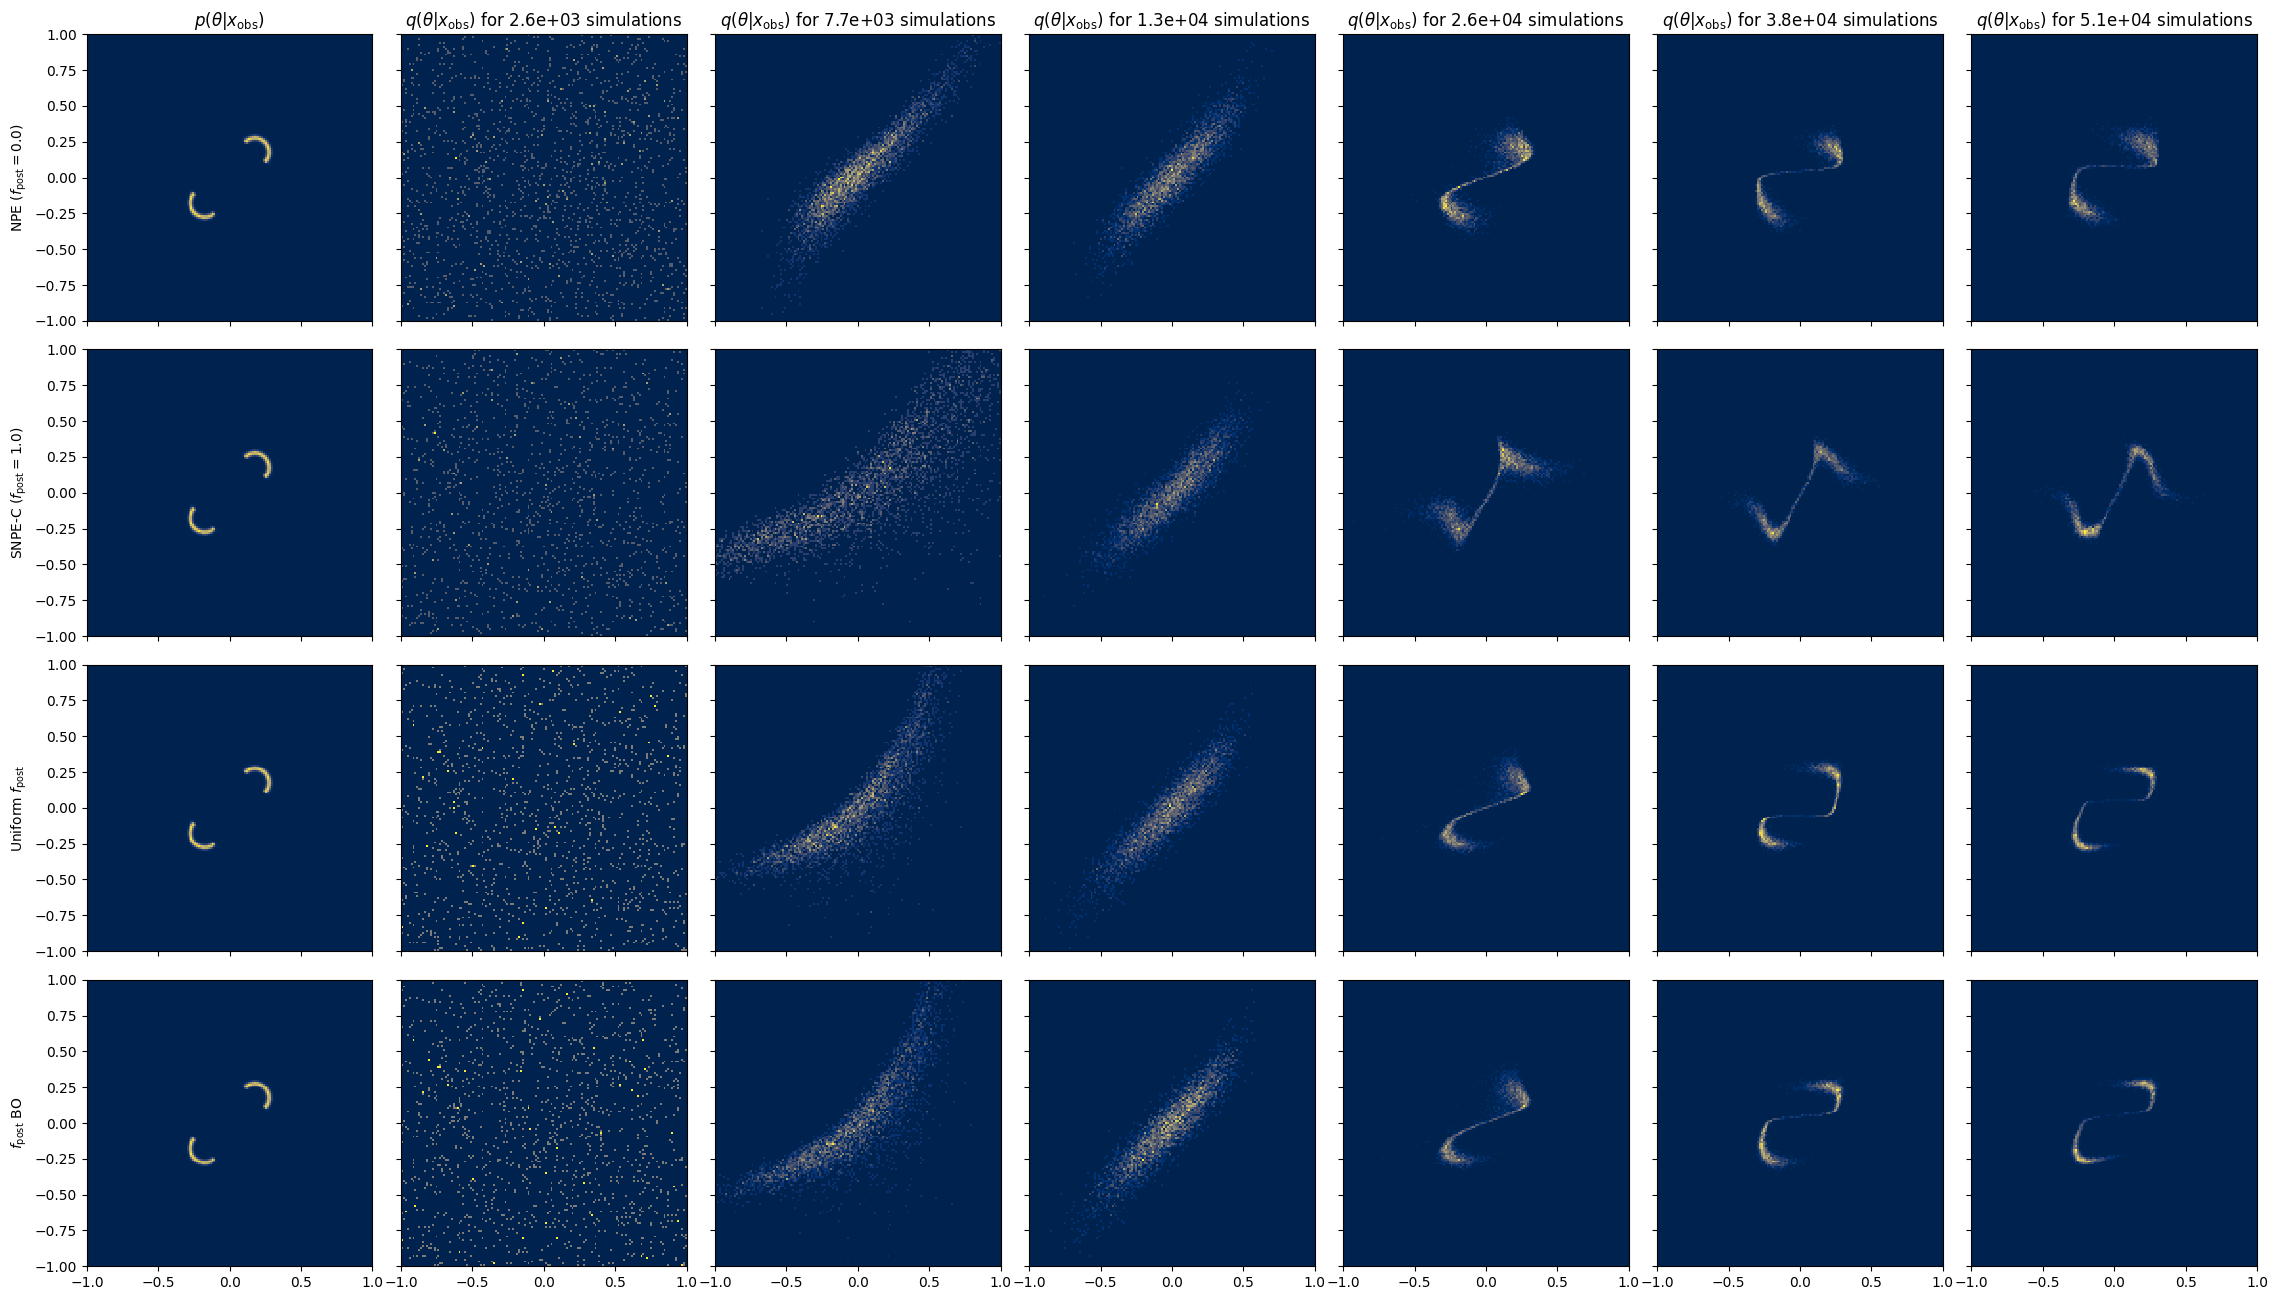

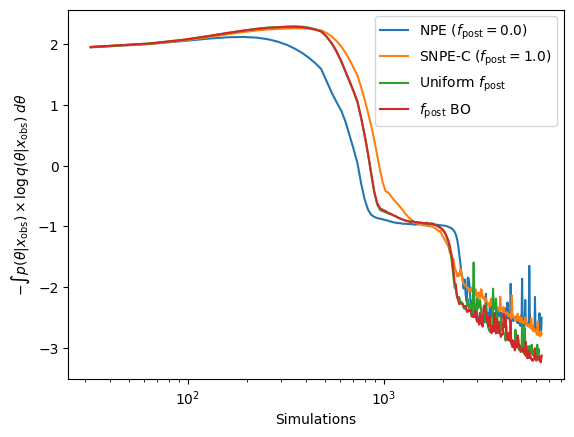

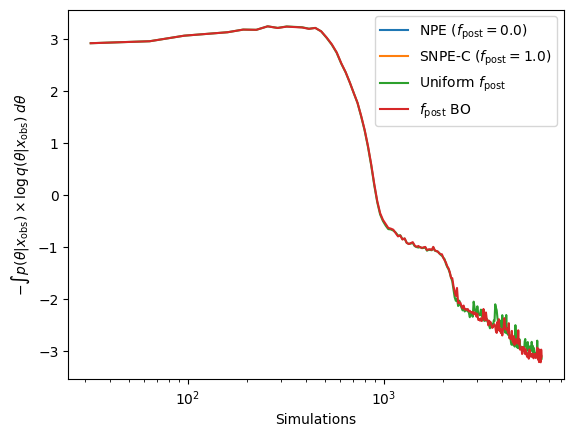

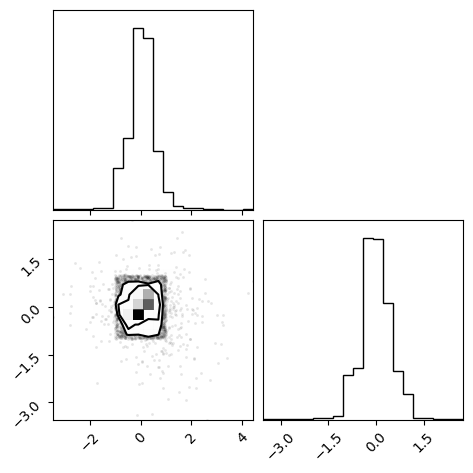

In [229]:
plot_samples(plt_indices = [10, 30, 50, 100, 150, 200])

for key in kl_dict:
    plt.plot(
        jnp.arange(1, len(kl_dict[key])+1) * training_sample_size,
        jnp.array(kl_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

for key in kl_approx_dict:
    plt.plot(
        jnp.arange(1, len(kl_approx_dict[key])+1) * training_sample_size,
        jnp.array(kl_approx_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

corner.corner(np.array(thetas))
plt.show()

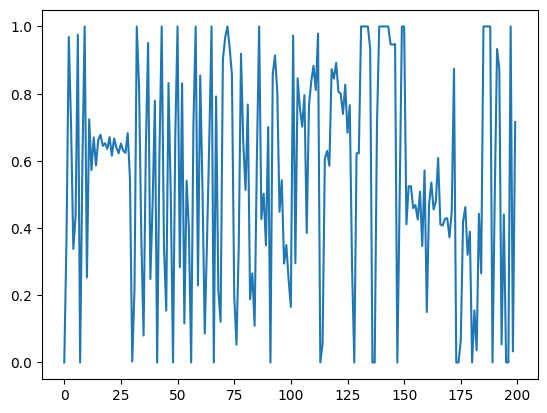

In [230]:
plt.plot(flow_weight_list)

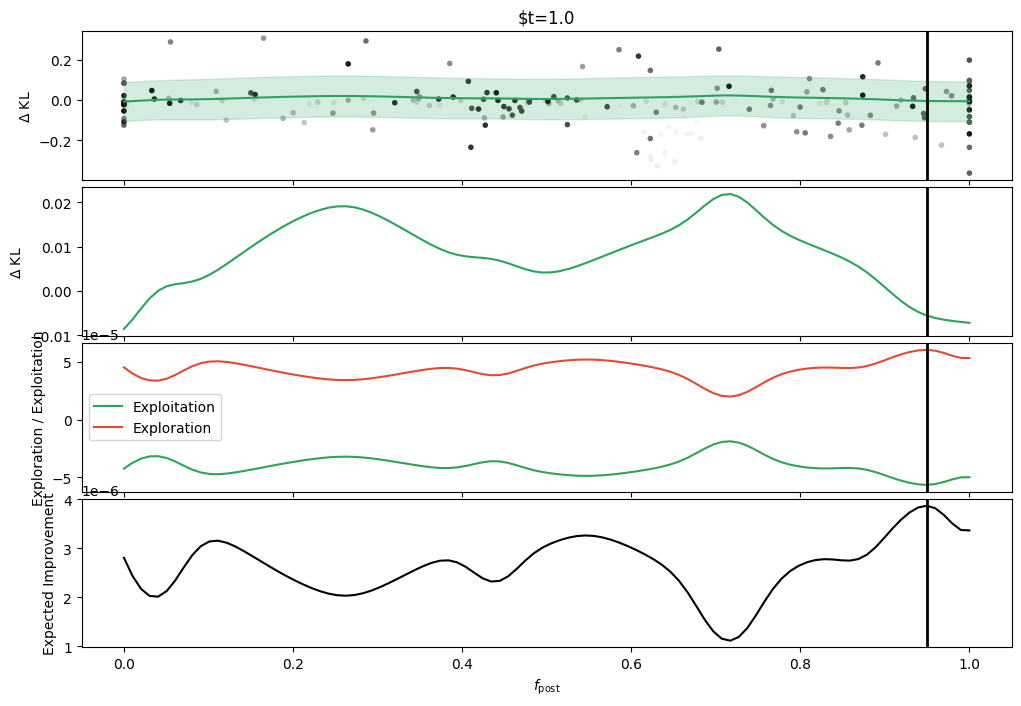

In [231]:
# Fit the GP with time and see how well it explains the data.
gp = get_new_gp(1)
gp.fit(features, f_vals)

feat_test = jnp.stack([jnp.ones(100), jnp.linspace(0,1,100)], axis=1)
mean, sigma = gp.predict(feat_test, return_std=True)
create_gp_plots(features, f_vals, feat_test, mean, sigma, title=r'$t=1.0')

In [232]:
# The name of this run
experiment = r'$f_\mathrm{post}$ BO No Time'
states_dict[experiment] = [state]
kl_dict[experiment] = []
kl_approx_dict[experiment] = []
flow_weight_list = []
# First state is blank state.
state_train = state

# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
flow_weight = 0.0
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, flow_weight)
rng_x = jax.random.split(rng_x, training_sample_size)
xs = draw_obs_conds(rng_x, thetas)

rng = jax.random.PRNGKey(2)
# Flow weight is always 0 for this experiment.
for seq_round in range(n_seq):

    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    batch_size = min(256, len(xs)) # Batch shouldn't be larger than the dataset.
    state_train, kl = train_state(
        xs, thetas, rng_train, state_train, n_epochs, batch_size
    )

    # Save the new state and the kl.
    states_dict[experiment].append(state_train)
    flow_weight_list.append(flow_weight)
    kl_dict[experiment].append(kl)
    print(f'Sequential round {seq_round}: {kl}, {flow_weight}')

    # Approximate kl
    approx_samples, _ = sample_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    log_obs_prob, _ = log_prob_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        approx_samples[0], jnp.zeros_like(approx_samples[0])
    )
    kl_approx_dict[experiment].append(-jnp.mean(log_obs_prob))

    # First samples are uniform, then we use GP fit.
    if seq_round < 5:
        flow_weight = jax.random.uniform(rng, minval=0.0, maxval=1.0)
    else:
        features = jnp.stack(
            [
                jnp.linspace(0, 1, len(flow_weight_list[1:]), endpoint=False),
                jnp.array(flow_weight_list)[1:]
            ],
            axis=1
        )

        # The value we're modeling is the change in the KL for our experiment
        f_vals = jnp.array(kl_dict[experiment])
        f_vals = f_vals[1:] - f_vals[:-1]

        # Fit the GP
        gp = get_new_gp(1)
        gp.fit(features[:, 1:], f_vals)
        feat_test = jnp.stack([jnp.ones(1000), jnp.linspace(0,1,1000)], axis=1)

        # Use the GP to predict the best next weight
        f_prime = np.min(f_vals)
        mean, sigma = gp.predict(feat_test[:, 1:], return_std=True)
        next_index = np.argmax(expected_improvement(mean, sigma, f_prime))
        flow_weight = feat_test[next_index, 1]

    # Get the new flow from the model and generate the new batch.
    flow_params, context = extract_flow_context(state_train, x_obs)
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_x = jax.random.split(rng, training_sample_size)
    x_batch = draw_obs_conds(rng_x, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0: 1.9494974613189697, 0.0
Sequential round 1: 2.0073037147521973, 0.3748607635498047
Sequential round 2: 2.069575309753418, 0.9686962366104126
Sequential round 3: 2.1300606727600098, 0.7055308818817139
Sequential round 4: 2.1809146404266357, 0.33790647983551025
Sequential round 5: 2.218503952026367, 0.43701374530792236


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 6: 2.241724967956543, 0.13613612949848175


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 7: 2.2504942417144775, 0.0


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 8: 2.2473020553588867, 0.5475475192070007


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 9: 2.242558479309082, 0.5375375151634216


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 10: 2.2356324195861816, 0.5375375151634216


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 11: 2.2215394973754883, 0.5345345139503479


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 12: 2.1996805667877197, 0.8388388156890869


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 13: 2.1727194786071777, 0.8338338136672974


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 14: 2.1420774459838867, 0.8208208084106445


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 15: 2.0636284351348877, 0.8128128051757812


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 16: 1.9601284265518188, 0.7897897958755493


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 17: 1.8272240161895752, 0.7857857942581177


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 18: 1.6684802770614624, 0.7757757902145386


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 19: 1.4967749118804932, 0.7667667269706726


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 20: 1.3336743116378784, 0.762762725353241


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 21: 1.1686508655548096, 0.7647647261619568


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 22: 0.9941665530204773, 0.7647647261619568


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 23: 0.7272557616233826, 0.7637637257575989


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 24: 0.4439292848110199, 0.7567567229270935


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 25: 0.13789337873458862, 0.7527527213096619


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 26: -0.18631361424922943, 0.7477477192878723


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 27: -0.4748866558074951, 0.7437437176704407


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 28: -0.650176465511322, 0.7437437176704407


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 29: -0.7147093415260315, 0.7487487196922302


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 30: -0.7464073300361633, 0.7527527213096619


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 31: -0.7644203901290894, 0.7547547221183777


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 32: -0.7863646745681763, 0.7567567229270935
Sequential round 33: -0.802573561668396, 0.7577577233314514
Sequential round 34: -0.8248918652534485, 0.7577577233314514
Sequential round 35: -0.8429703116416931, 0.7587587237358093
Sequential round 36: -0.8586898446083069, 0.7577577233314514
Sequential round 37: -0.8763495087623596, 0.7587587237358093
Sequential round 38: -0.8904320597648621, 0.7577577233314514
Sequential round 39: -0.9040319919586182, 0.7587587237358093
Sequential round 40: -0.9161749482154846, 0.7577577233314514
Sequential round 41: -0.9221921563148499, 0.7577577233314514
Sequential round 42: -0.9316490292549133, 0.7567567229270935
Sequential round 43: -0.929302453994751, 0.7567567229270935
Sequential round 44: -0.9406684041023254, 0.7547547221183777
Sequential round 45: -0.9430566430091858, 0.7527527213096619


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 46: -0.9429242610931396, 0.7537537217140198


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 47: -0.9485143423080444, 0.7567567229270935


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 48: -0.9508931040763855, 0.7577577233314514


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 49: -0.9521729350090027, 0.7587587237358093


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 50: -0.9550100564956665, 0.7597597241401672


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 51: -0.9535580277442932, 0.7597597241401672


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 52: -0.9636988043785095, 0.7607607245445251


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 53: -0.9715974926948547, 0.7607607245445251


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 54: -0.9726948142051697, 0.7607607245445251


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 55: -0.9753825664520264, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 56: -0.9893531799316406, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 57: -1.0031335353851318, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 58: -1.0176178216934204, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 59: -1.0341001749038696, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 60: -1.0543969869613647, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 61: -1.0781000852584839, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 62: -1.1056827306747437, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 63: -1.1473194360733032, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 64: -1.1956835985183716, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 65: -1.2671579122543335, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 66: -1.3185690641403198, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 67: -1.4503710269927979, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 68: -1.5655524730682373, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 69: -1.8293814659118652, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 70: -2.03716778755188, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 71: -2.1014044284820557, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 72: -2.0847718715667725, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 73: -2.2703330516815186, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 74: -2.2383368015289307, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 75: -2.3112502098083496, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 76: -2.2811665534973145, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 77: -2.3459408283233643, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 78: -2.3422374725341797, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 79: -2.4069020748138428, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 80: -2.258030652999878, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 81: -2.418022871017456, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 82: -2.4258196353912354, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 83: -2.402510643005371, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 84: -2.3584985733032227, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 85: -2.422224998474121, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 86: -2.4471495151519775, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 87: -2.4376790523529053, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 88: -2.422914505004883, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 89: -2.4470620155334473, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 90: -2.488009214401245, 0.7607607245445251


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 91: -2.4610471725463867, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 92: -2.5109448432922363, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 93: -2.538872241973877, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 94: -2.5031468868255615, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 95: -2.5417590141296387, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 96: -2.5002858638763428, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 97: -2.568740129470825, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 98: -2.555820941925049, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 99: -2.5878984928131104, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 100: -2.5419952869415283, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 101: -2.545499563217163, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 102: -2.5081117153167725, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 103: -2.5359714031219482, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 104: -2.6067395210266113, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 105: -2.581526279449463, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 106: -2.6541080474853516, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 107: -2.592412233352661, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 108: -2.650231122970581, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 109: -2.643507480621338, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 110: -2.6612212657928467, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 111: -2.705005645751953, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 112: -2.7776448726654053, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 113: -2.809752941131592, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 114: -2.776658058166504, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 115: -2.779026746749878, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 116: -2.775477409362793, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 117: -2.832409381866455, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 118: -2.8164968490600586, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 119: -2.8820199966430664, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 120: -2.9316561222076416, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 121: -2.9066574573516846, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 122: -2.9279184341430664, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 123: -2.964179515838623, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 124: -2.9403374195098877, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 125: -2.999605178833008, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 126: -2.9694604873657227, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 127: -3.021181106567383, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 128: -2.983513593673706, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 129: -3.048650026321411, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 130: -3.026583671569824, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 131: -3.077897310256958, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 132: -3.0467517375946045, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 133: -3.07012939453125, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 134: -3.077080488204956, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 135: -3.0853168964385986, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 136: -2.9688682556152344, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 137: -3.0389277935028076, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 138: -3.083522081375122, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 139: -3.0740339756011963, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 140: -3.12837553024292, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 141: -3.0548107624053955, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 142: -3.1071085929870605, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 143: -3.135188579559326, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 144: -3.0717365741729736, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 145: -3.1364965438842773, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 146: -3.1529693603515625, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 147: -3.091665029525757, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 148: -3.102905035018921, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 149: -3.114377498626709, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 150: -3.1484787464141846, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 151: -3.1518242359161377, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 152: -3.153409957885742, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 153: -3.1720917224884033, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 154: -3.1611130237579346, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 155: -3.1211178302764893, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 156: -3.1750905513763428, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 157: -3.2040250301361084, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 158: -3.2056925296783447, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 159: -3.1636481285095215, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 160: -3.174382448196411, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 161: -3.2007288932800293, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 162: -3.210446834564209, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 163: -3.09427547454834, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 164: -3.219822406768799, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 165: -3.187410593032837, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 166: -3.1594111919403076, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 167: -3.2181575298309326, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 168: -3.2141451835632324, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 169: -3.149587392807007, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 170: -3.0463898181915283, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 171: -3.215534210205078, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 172: -3.183566093444824, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 173: -3.2015137672424316, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 174: -3.240647315979004, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 175: -3.2223544120788574, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 176: -3.224930763244629, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 177: -3.1919381618499756, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 178: -3.230457305908203, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 179: -3.22940731048584, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 180: -3.1964640617370605, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 181: -3.235215187072754, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 182: -3.192652702331543, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 183: -3.2222793102264404, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 184: -3.1996703147888184, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 185: -3.241309404373169, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 186: -3.2420618534088135, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 187: -3.2264418601989746, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 188: -3.2655880451202393, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 189: -3.2550554275512695, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 190: -3.222985029220581, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 191: -3.247842788696289, 0.762762725353241


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 192: -3.2377405166625977, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 193: -3.2400104999542236, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 194: -3.251523733139038, 0.762762725353241


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 195: -3.2154595851898193, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 196: -3.2360167503356934, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 197: -3.2217183113098145, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 198: -3.2319512367248535, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 199: -3.2176358699798584, 0.7617617249488831


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


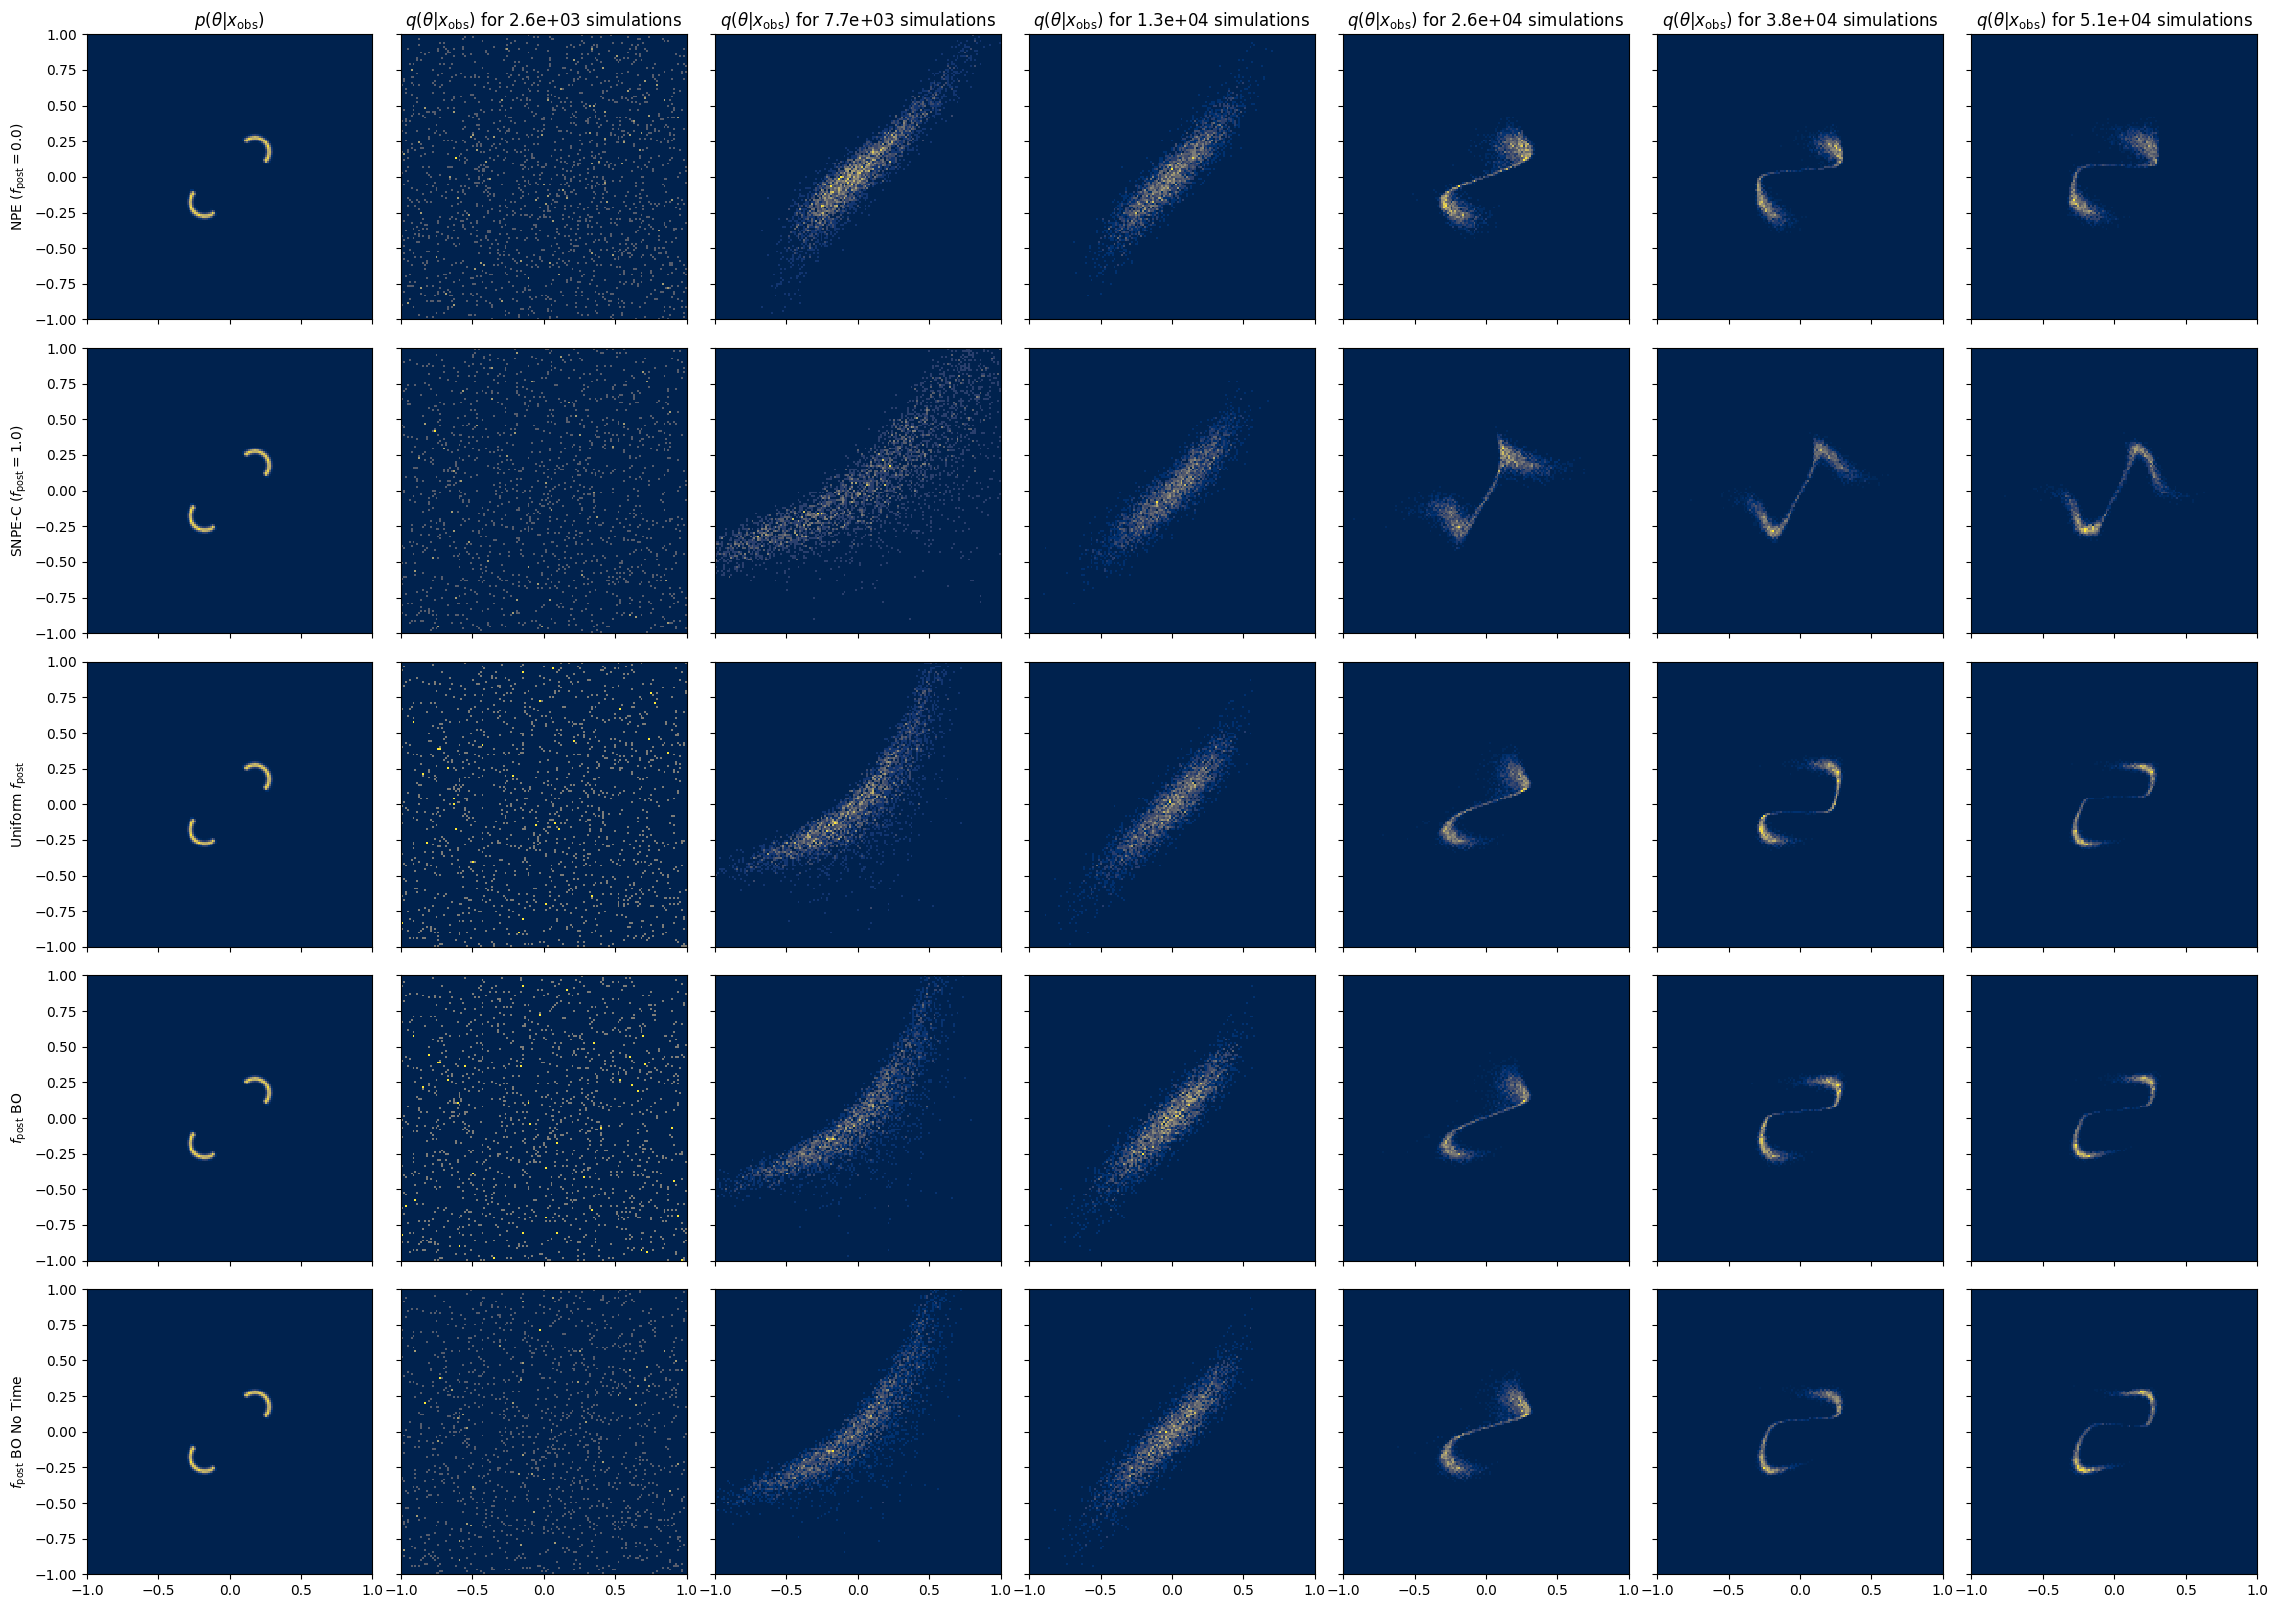

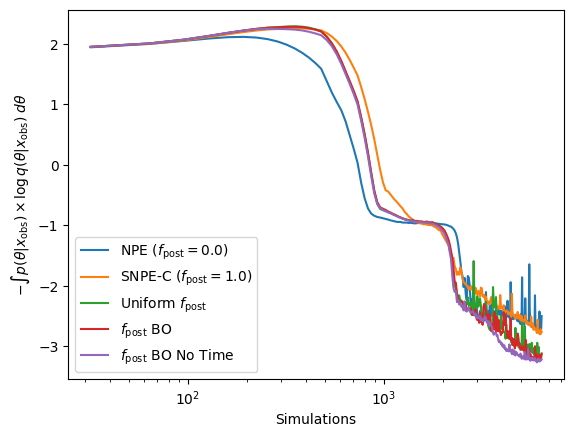

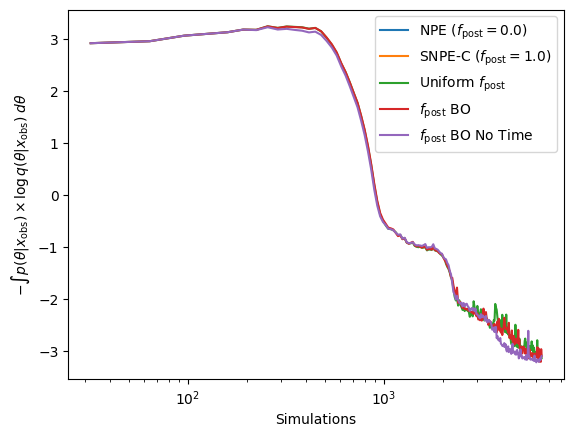

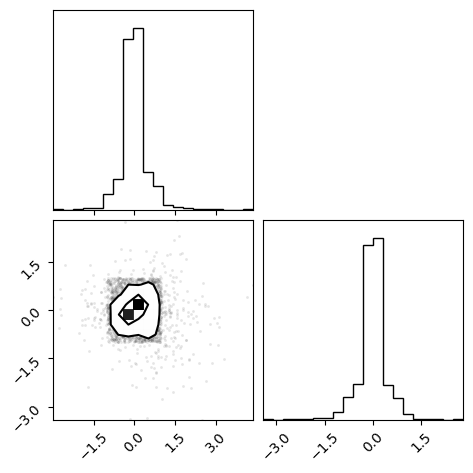

In [233]:
plot_samples(plt_indices = [10, 30, 50, 100, 150, 200])

for key in kl_dict:
    plt.plot(
        jnp.arange(1, len(kl_dict[key])+1) * training_sample_size,
        jnp.array(kl_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

for key in kl_approx_dict:
    plt.plot(
        jnp.arange(1, len(kl_approx_dict[key])+1) * training_sample_size,
        jnp.array(kl_approx_dict[key]), label=key
    )
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

corner.corner(np.array(thetas))
plt.show()

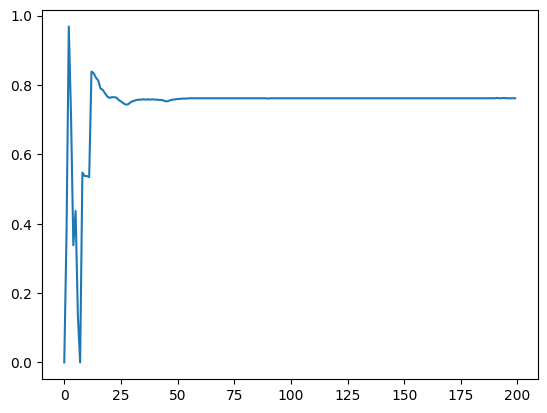

In [234]:
plt.plot(flow_weight_list)

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


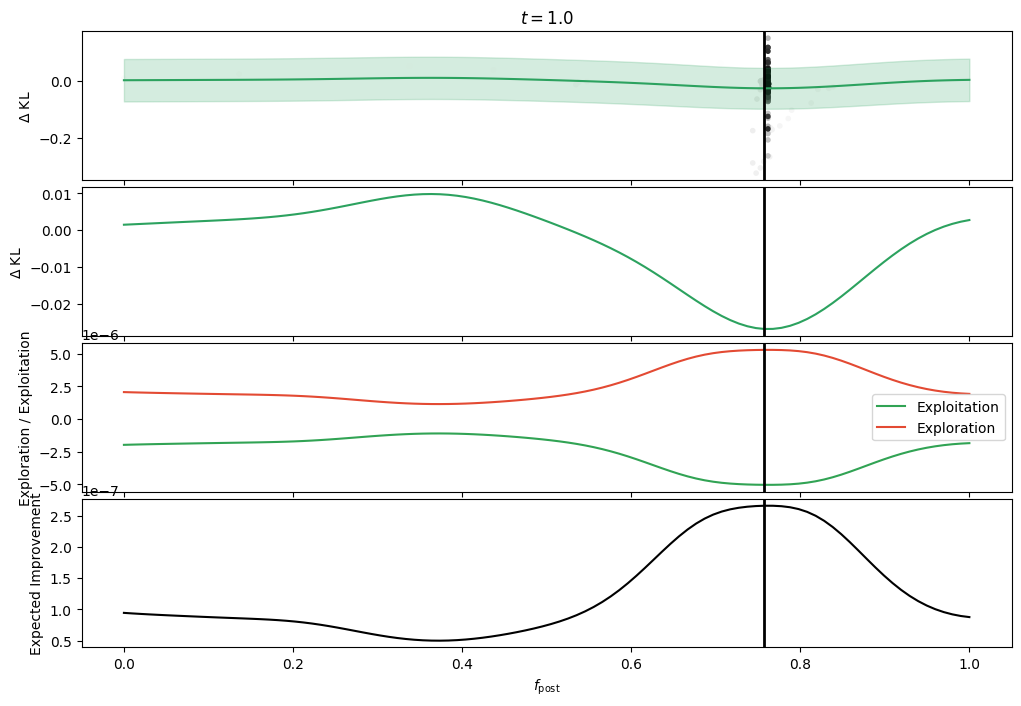

In [238]:
# Fit the GP with time and see how well it explains the data.
gp = get_new_gp(1)
gp.fit(features[:, 1:], f_vals)

feat_test = jnp.stack([jnp.ones(100), jnp.linspace(0,1,100)], axis=1)
mean, sigma = gp.predict(feat_test[:, 1:], return_std=True)
create_gp_plots(features, f_vals, feat_test, mean, sigma, title=r'$t=1.0$')

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from scipy.stats import norm

def expected_improvement(mean, sigma, f_prime):
    a_ei = (f_prime - mean) * norm.cdf(f_prime, loc=mean, scale=sigma)
    a_ei += sigma ** 2 * norm.pdf(f_prime, loc=mean, scale=sigma)
    return a_ei

def get_new_gp():
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1e0, (1e-3, 1e3)) + WhiteKernel(1e-2, (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)
    return gp
gp = get_new_gp()

In [ ]:
gp.fit(np.array(frac_dif_list)[:,None], kl_dif_list_bo)
mean, sigma = gp.predict(frac_test[:,None], return_std=True)
next_index = np.argmax(expected_improvement(mean, sigma, np.min(frac_dif_list)))
flow_weight = frac_test[next_index]
print(flow_weight)

mean, sigma = gp.predict(frac_test[:,None], return_std=True)
plt.plot(frac_dif_list, kl_dif_list_bo, '.')
plt.fill_between(
    frac_test, (mean-sigma), (mean+sigma), alpha=0.2
)
plt.show()

In [ ]:
# The prior distribution and the flow from which we will sample.
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(batch_size, 2), minval=-1.0, maxval=1.0
)
# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Keep a list of the state after each epoch.
rng = jax.random.PRNGKey(0)
state_list_bo = [state]
kl_list_bo = []
kl_dif_list_bo = []
frac_dif_list = []

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
flow_weight = 0.5
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_batch = jax.random.split(rng_x, batch_size)
xs = draw_obs_conds(rng_batch, thetas)

rng = jax.random.PRNGKey(2)
n_seq = 20
n_epochs = 10
frac_test = np.linspace(0.0, 1.0, 1000)
for seq_round in range(n_seq):
    print(f'Sequential round {seq_round}, {flow_weight}')
    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    state_train, kl = train_state(
        xs, thetas, rng_train, state_list_bo[-1], n_epochs, min(128, len(xs))
    )

    # Save the new state and the kl.
    state_list_bo.append(state_train)
    kl_list_bo.append(kl)
    if seq_round > 0:
        kl_dif_list_bo.append(kl_list_bo[-1] - kl_list_bo[-2])
        frac_dif_list.append(flow_weight)
        if seq_round > 5:
            gp.fit(np.array(frac_dif_list)[:,None], kl_dif_list_bo)
            mean, sigma = gp.predict(frac_test[:,None], return_std=True)
            next_index = np.argmax(expected_improvement(mean, sigma, np.min(frac_dif_list)))
            flow_weight = frac_test[next_index]
        else:
            flow_weight = jax.random.uniform(rng)

    # Get the new flow from the model.
    flow_params, context = extract_flow_context(state_train, x_obs)

    # Generate the new batch.
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_batch = jax.random.split(rng, batch_size)
    x_batch = draw_obs_conds(rng_batch, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


In [ ]:
plt_indices = [1, 10, 20, 100, 200]
sample_shape = (4096,)

fig, ax = plt.subplots(
    1, len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1),4), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.1}, dpi=100
)
n_bins = 150

ax[0].set_title(r'$p(\theta|x_\mathrm{obs})$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)

for plt_i, i in enumerate(plt_indices):
    t_samp, _ = sample_func(
        {'params': state_list_cons[i].params, 'batch_stats': state_list_cons[i].batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    t_samp = jnp.squeeze(t_samp)
    ax[plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * (i):.1e} simulations')
    ax[plt_i+1].hist2d(
        t_samp[:, 0], t_samp[:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
plt.show()

plt.plot(jnp.arange(1, len(kl_list_cons)+1) * batch_size, jnp.array(kl_list_cons))
plt.plot(jnp.arange(1, len(kl_list_post)+1) * batch_size, jnp.array(kl_list_post))
plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior))
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta_\mathrm{obs}|x_\mathrm{obs})$')
plt.show()